# Lasso

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), it performs a regression trying to minimize the sum of squared error by estimating **sparse coefficients**. Therefore, it tries to minimize the following quantity
$$ \frac{1}{2 * n_{samples}} ||y - Xw||^2_2 + \alpha  ||w||_1 , $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of **sparsity** (this regularization is called $L_1$ as it uses the $L_1$ norm of the coefficient vector). 

(*given a vector $x$ with 2 components, the $L_1$ norm is given by $|x_1| + |x_2|$*)

It is a very useful regularization in the case only a few coefficients are important for the final prediction. In fact, by using the $L_1$ norm of the coefficient vector, it tends to set the unimportant coefficients to 0. It is then a useful algorithm also for **automatic feature selection**.

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model, grid_results

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/02_linear_models.csv'  # for storing results
modelname='Lasso'
kfolds = KFold(10, shuffle=True, random_state=541)

In [2]:
Lasso()

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

# Hyperparameters and their role

* **alpha**: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression, but it is not advised for numerical reasons.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that controls the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **positive**: when True, it forces the coefficients to be positive.
* **precompute**: Whether to use a precomputed Gram matrix to speed up calculations. 'auto' is an option
* **random_state**: relevant only for one of the solver since it is stochastic (the 'sag' solver)
* **selection**: if set to 'random', a random coefficient is updated every iteration rather than looping over features sequentially. It can speed up the convergence.
* **tol**: the precision of the solution
* **warm_start**: if True, it reuses the previously fitted model to initialize again. This can be useful in a grid search, where you can reuse aspects of the model learnt from the previous parameter value and thus save time.


We could perform default hyperparameters as it generally gives a good indication of the model performance to compare results. However, this time we can control more the behavior of the model. This section will do just that.

First, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, and solver type. Due to the need of seeing some pattern, we will use a dataset without noise in order to have errors at an order of magnitude that let us see the variation when the hyperparameter varies. Later, using more complex dataset, we will see more interesting patterns.

In [5]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.1, 5, 0.05)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False], 
              'lasso__precompute': [True, False]}

res = grid_results(model, kfolds, param_grid, data_name='data/simulated/100_feat_65_inf_nonoise.csv', sample=500)

res.head()

{'lasso__alpha': 0.1, 'lasso__positive': True, 'lasso__precompute': True, 'lasso__selection': 'random', 'lasso__tol': 0.0001}


param_lasso__alpha param_lasso__positive param_lasso__precompute  \
0                0.1                  True                    True   
1                0.1                  True                   False   
2                0.1                  True                    True   
3                0.1                  True                   False   
4                0.1                  True                    True   

  param_lasso__selection param_lasso__tol  mean_train_score  std_train_score  \
0                 random           0.0001         -0.698186         0.010320   
1                 random           0.0001         -0.698186         0.010320   
2                 random           0.0002         -0.699278         0.010099   
3                 random           0.0002         -0.699278         0.010099   
4                 cyclic           0.0001         -0.700188         0.009850   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0        -0.813422        0.091226       0.005291      0.002482   
1        -0.813422        0.091226       0.008860      0.003784   
2        -0.814204        0.091484       0.004826      0.000956   
3        -0.814204        0.091484       0.005884      0.001682   
4        -0.815059        0.092965       0.024386      0.014413   

   mean_score_time  std_score_time  
0         0.001581        0.000054  
1         0.001715        0.000090  
2         0.001541        0.000043  
3         0.001772        0.000230  
4         0.005136        0.002105

Let's start with two hyperparameters that should not affect the performance of the model but rather the run time. We see the how faster the model is when the `selection=='random'` and when the Gram matrix is precomputed.

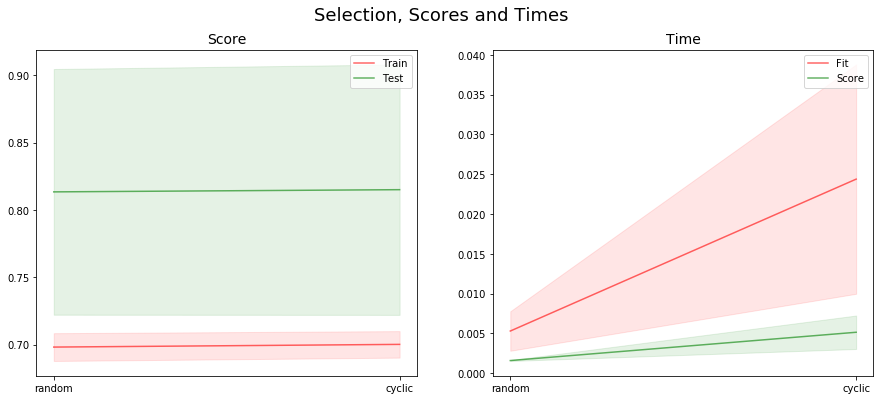

In [6]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0001) & 
                            (res.param_lasso__positive==True) & 
                            (res.param_lasso__precompute==True)], 'param_lasso__selection', 'Selection')

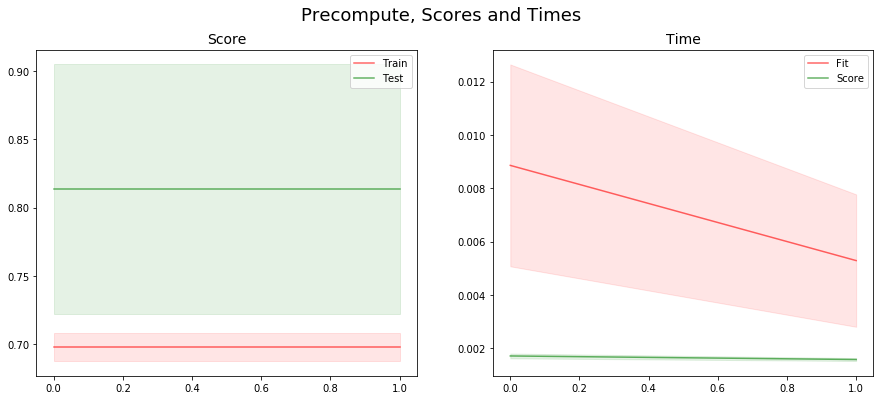

In [7]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0001) & 
                            (res.param_lasso__positive==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__precompute', 'Precompute')

On the other hand, the hyperparameter `positive`, while being very important in terms of model interpretability, is not playing a role in terms of performance or speed, although the fluctuations in training time are much higher when it is set to True

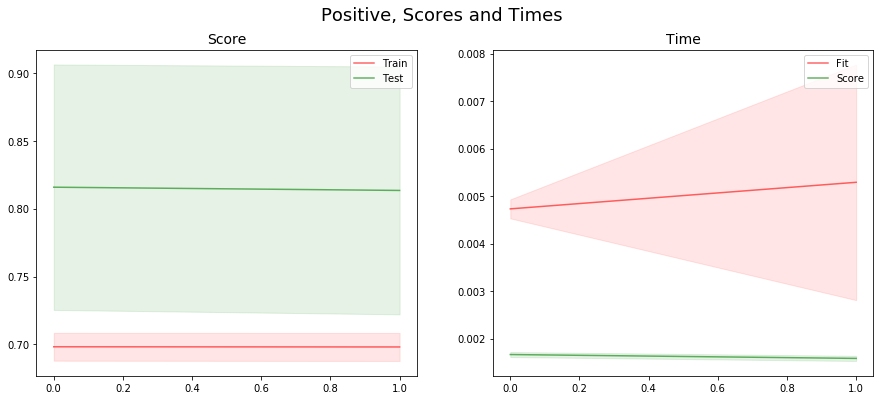

In [10]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.1) & 
                            (res.param_lasso__tol==0.0001) & 
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__positive', 'Positive')

The most important hyperparameter is `alpha`, the regularizing term. As we have seen in the previous notebook, **more regularization leads to learning the training data less and less**. In the case of Lasso regularization, this means setting to 0 more and more coefficients and, on this set of data, this means having a model that has a worse and worse performance the more we regularize.

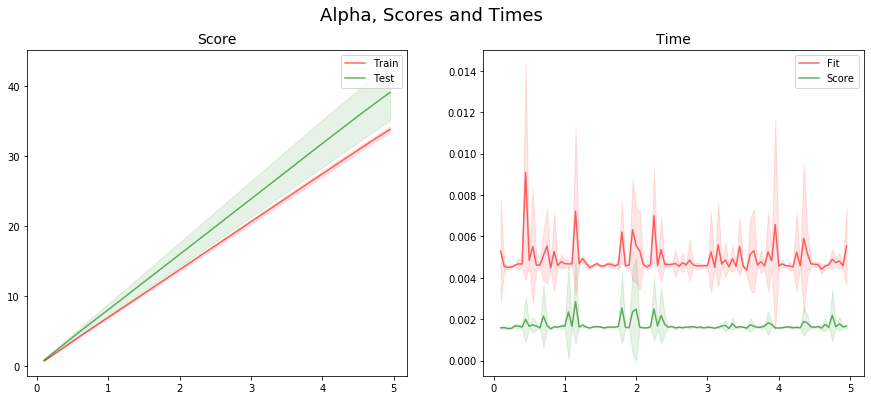

In [11]:
hyp.plot_hyperparameter(res[(res.param_lasso__positive == True) & 
                            (res.param_lasso__tol==0.0001) & 
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__alpha', 'Alpha')

The last parameter is the tolerance and we can see in this joint plot that its importance is very limited, compared to the role of `alpha`.

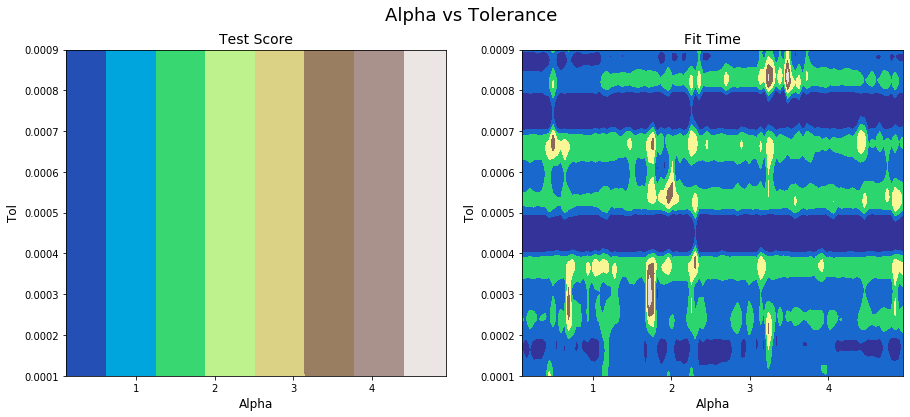

In [12]:
hyp.plot_two_hyperparms(res[(res.param_lasso__positive == True) &
                            (res.param_lasso__precompute==True) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

In order to not move to the next section with a partial view of the hyperparameters role, we test the model on a different set of data

In [13]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.1, 5, 0.05)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False], 
              'lasso__precompute': [True, False]}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=1000)

res.head()

{'lasso__alpha': 0.9000000000000002, 'lasso__positive': False, 'lasso__precompute': True, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0009000000000000001}


param_lasso__alpha param_lasso__positive param_lasso__precompute  \
0                0.9                 False                   False   
1                0.9                 False                    True   
2               0.95                 False                   False   
3               0.95                 False                    True   
4               0.85                 False                   False   

  param_lasso__selection param_lasso__tol  mean_train_score  std_train_score  \
0                 cyclic           0.0009        -12.205951         0.130209   
1                 cyclic           0.0009        -12.205951         0.130209   
2                 cyclic           0.0009        -12.216600         0.131641   
3                 cyclic           0.0009        -12.216600         0.131641   
4                 cyclic           0.0009        -12.196233         0.128890   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0       -12.942899        1.110138       0.007217      0.000248   
1       -12.942899        1.110138       0.007846      0.001183   
2       -12.943575        1.108262       0.007309      0.000355   
3       -12.943575        1.108262       0.007587      0.000307   
4       -12.944267        1.111217       0.008129      0.000558   

   mean_score_time  std_score_time  
0         0.001982        0.000070  
1         0.002767        0.002014  
2         0.001970        0.000049  
3         0.001952        0.000102  
4         0.002106        0.000271

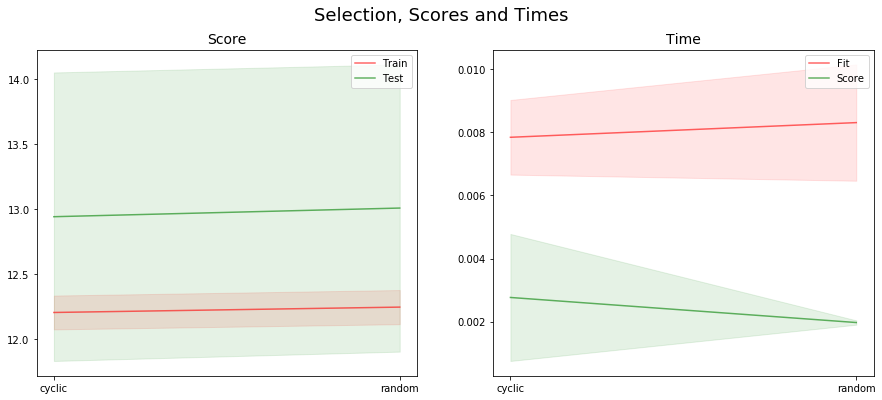

In [14]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.9000000000000002) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__precompute==True)], 'param_lasso__selection', 'Selection')

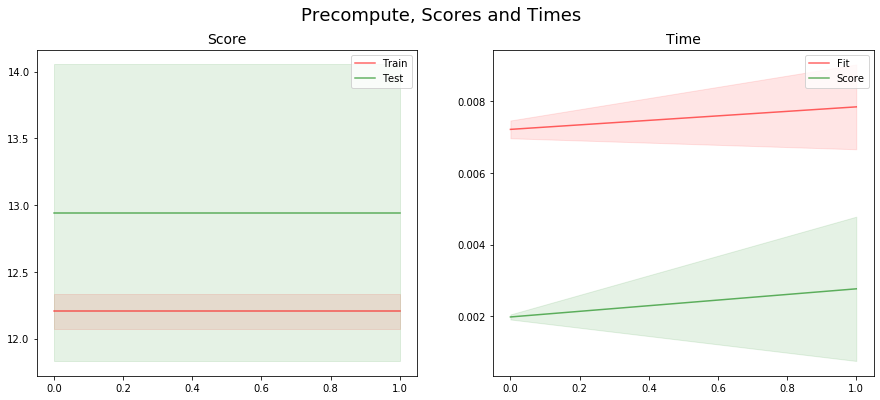

In [15]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.9000000000000002) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__precompute', 'Precompute')

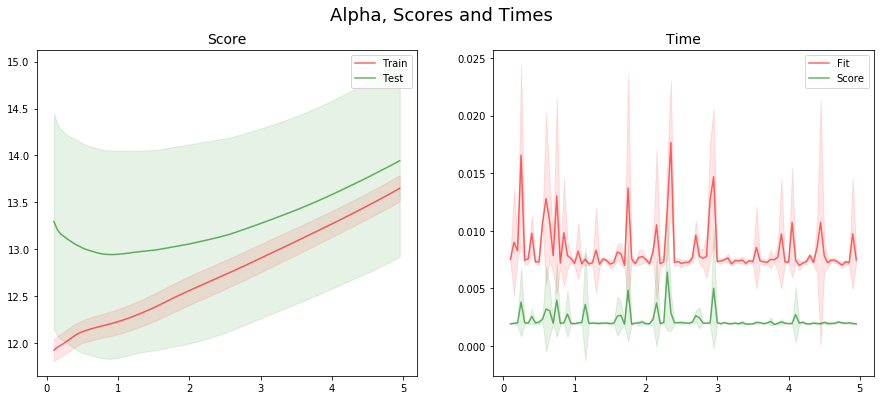

In [16]:
hyp.plot_hyperparameter(res[(res.param_lasso__precompute == True) & 
                            (res.param_lasso__tol==0.0009000000000000001) & 
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__alpha', 'Alpha')

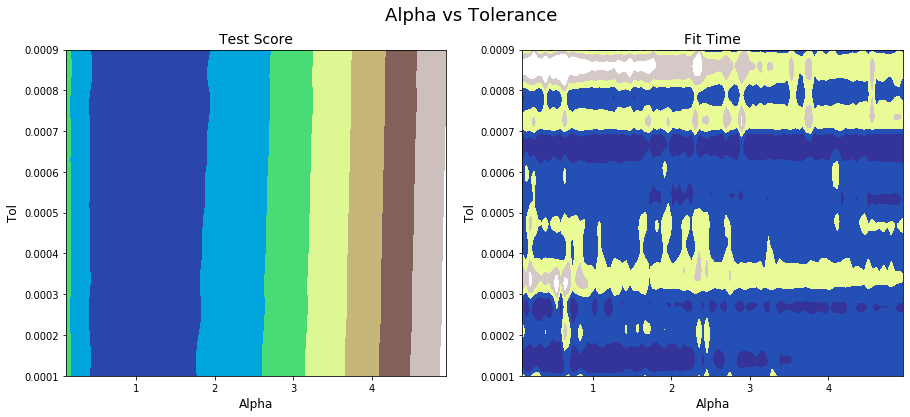

In [17]:
hyp.plot_two_hyperparms(res[(res.param_lasso__precompute == True) &
                            (res.param_lasso__positive==False) & 
                            (res.param_lasso__selection=='cyclic')], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

In this case, we see that both `precompute` and `selection` do not play a relevant role in improving the speed of the model. This time, we see that `alpha` can help the model in its predictions. In fact, in this case the target is generated by using only a few features and thus ignoring the useless ones is improving the model. We also see that `tol` can have some influence on the model performance but it is definitely `alpha` the hyperparameter to tune.


# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [18]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(random_state=325))])

params = {'alpha': 1}

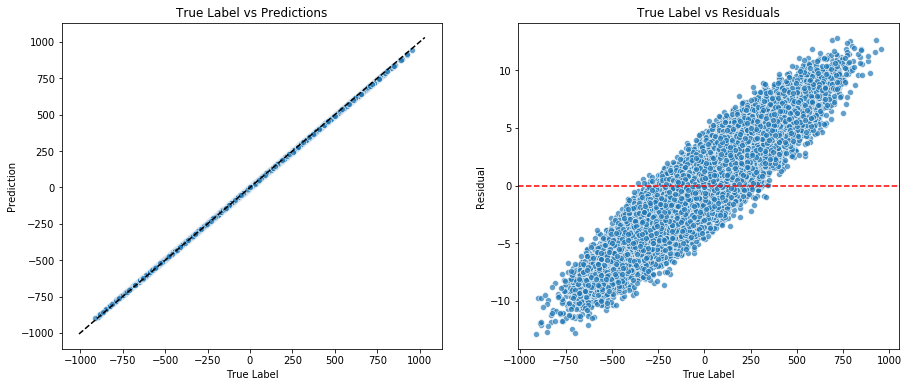

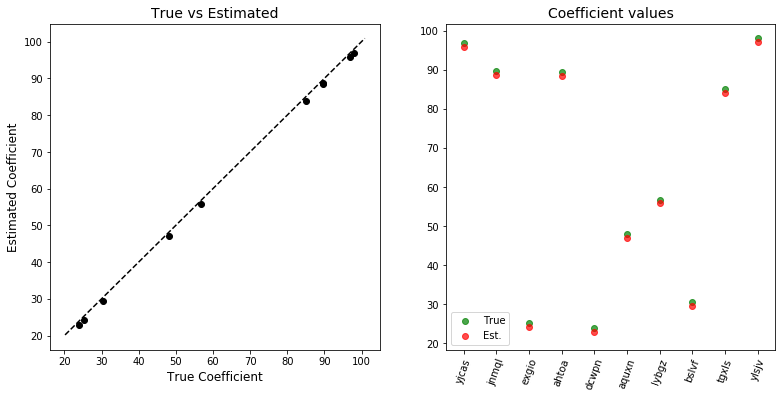

MAE: 		 2.52555
MSE: 		 10.03685
Max Error: 	 12.86134
Expl Variance: 	 0.9998


In [19]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

All the coefficients are underestimated and the performance is worse than before. As in the previous case, the regularization is causing the model to underfit the data and, in contrast with the $L_2$ regularization, this is compromising both performance and coefficients' estimates.

The same can be said when we introduce some noise in the data, although the drop in performance is less visible.

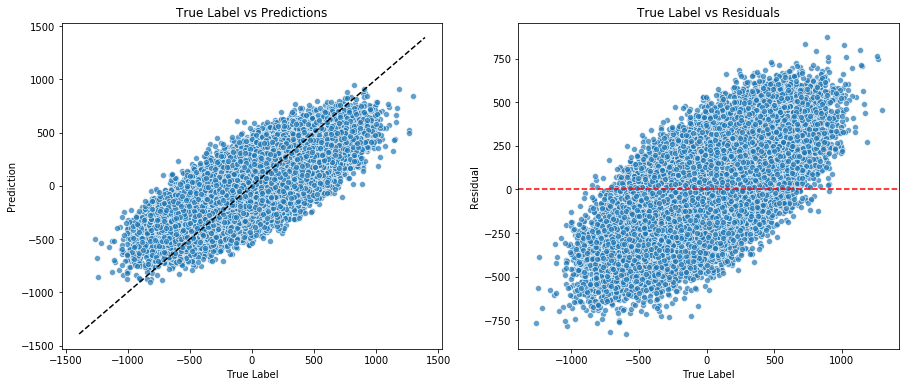

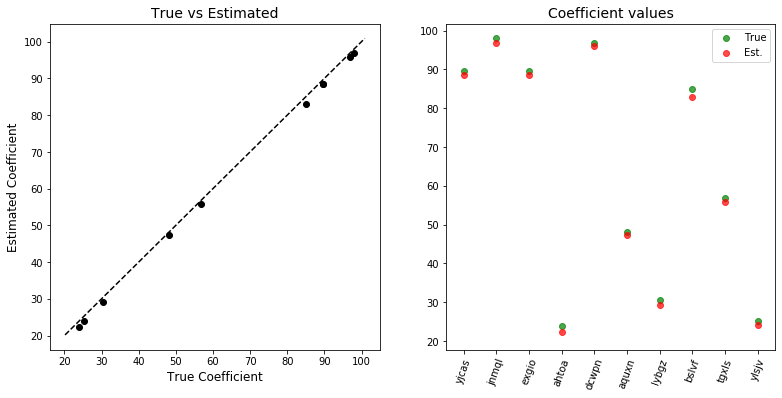

MAE: 		 159.17643
MSE: 		 39913.49636
Max Error: 	 870.55353
Expl Variance: 	 0.55326


In [20]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This kind of regularization is expected to be more useful when we are training with features that have no relation with the target variable, since the model will more likely set their coefficients to 0. This is the case for the next example, where only 65 out of the 100 features are relevant.

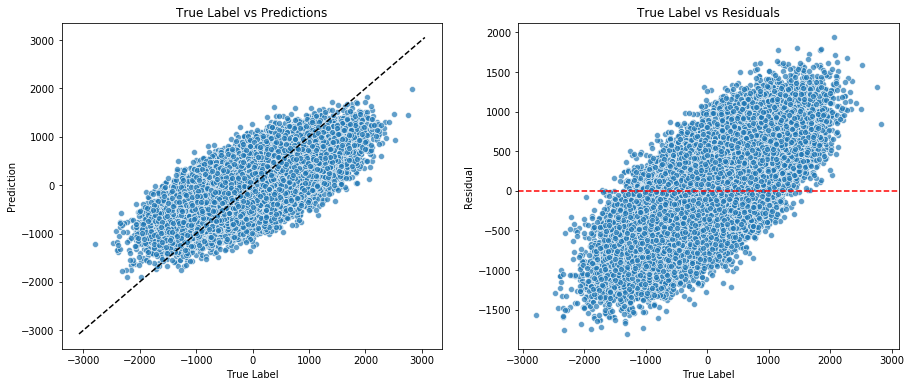

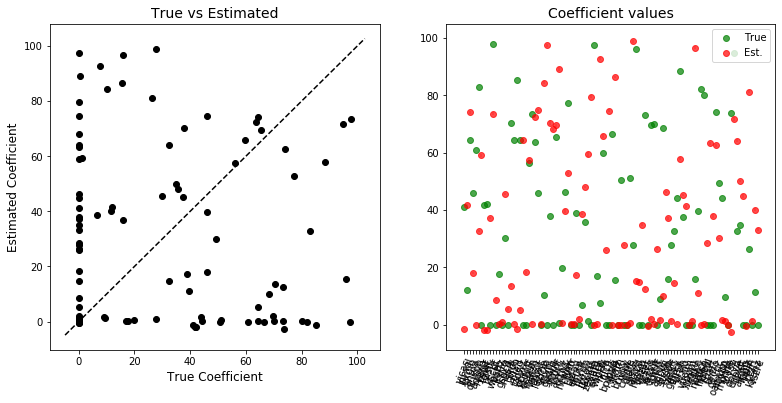

MAE: 		 359.49162
MSE: 		 202607.06105
Max Error: 	 1937.26028
Expl Variance: 	 0.48914


In [21]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.55, random_state=325))])

params = {'alpha': 0.55}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We did not cure entirely the fact that the model sets to 0 many non-zero coefficients but we can at least see a small improvement in performance.

The same cannot be said if we also introduce some correlation between features.

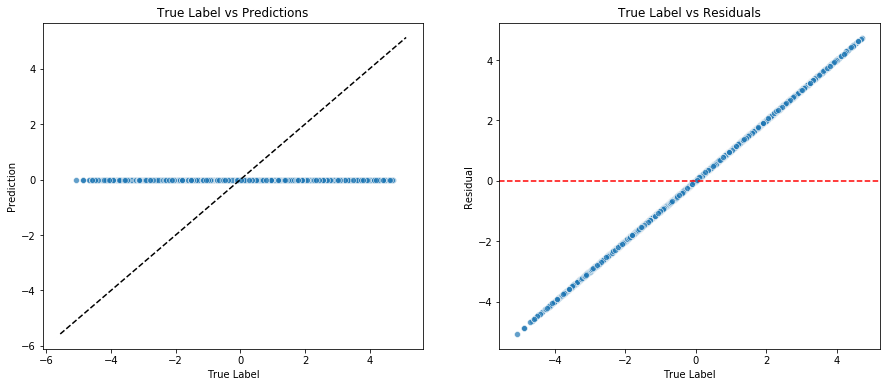

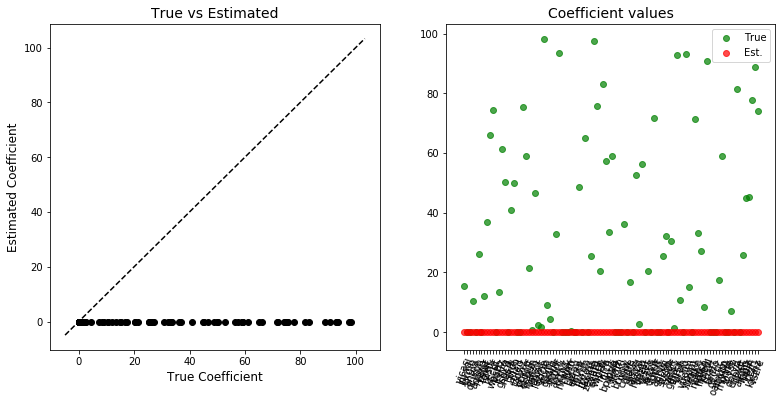

MAE: 		 0.93297
MSE: 		 1.36511
Max Error: 	 5.06419
Expl Variance: 	 -1e-05


In [22]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As the model is predicting nothing but 0's.

# Number of instances

The behavior is not changing much when we introduce the regularization. However, as in the case of `Ridge` the implementation is much more optimized and thus we get a better performance in terms of speed.

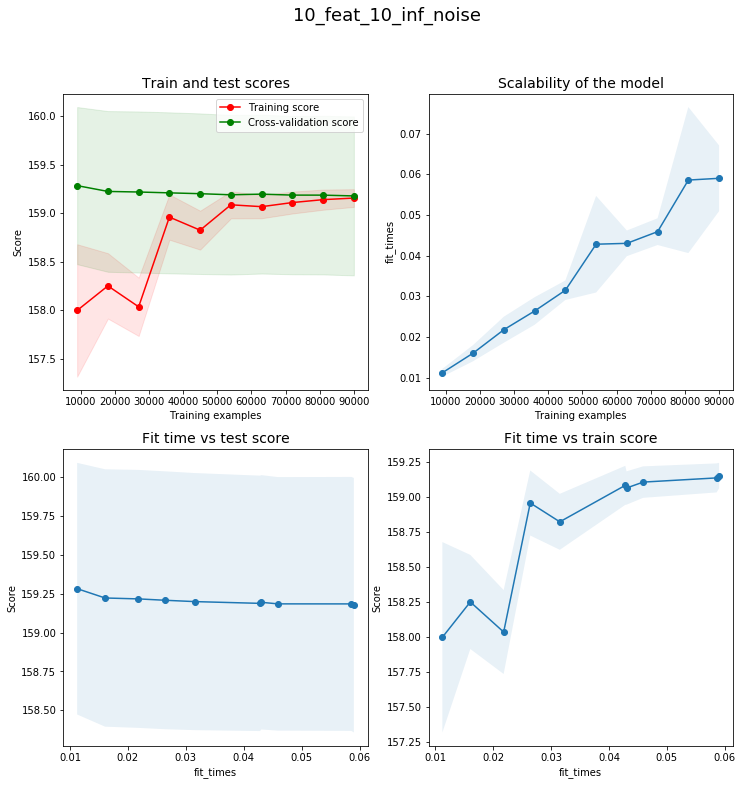

In [23]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds without the regularization, while now it is around 0.55 seconds.

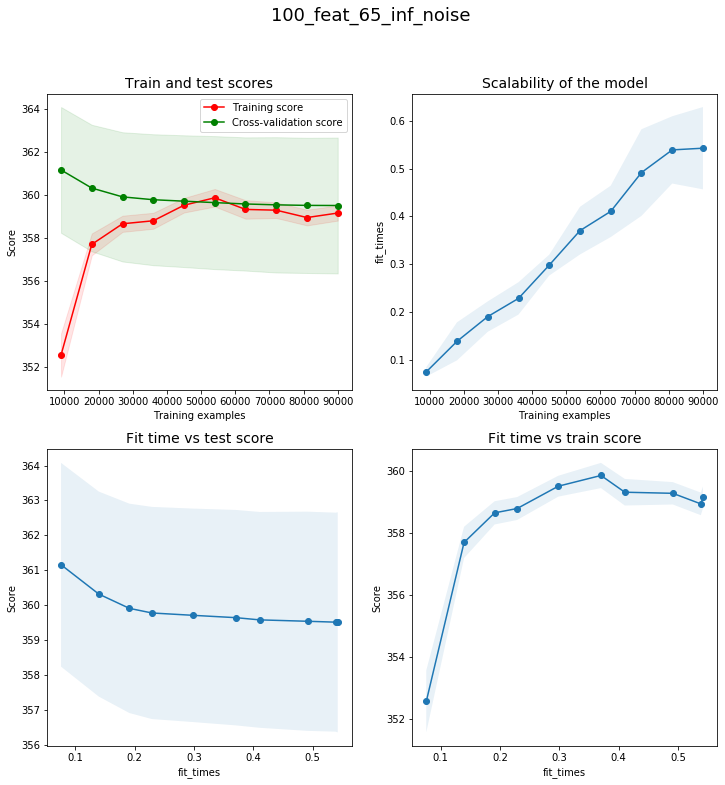

In [24]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

In the previous notebook we said that, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`. For numerical reasons, it is not adviced to do the same with `Lasso(alpha=0)`.

By reducing the number of training instances, we observe a less accurate set of predictions and the same underestimation of the coefficients.

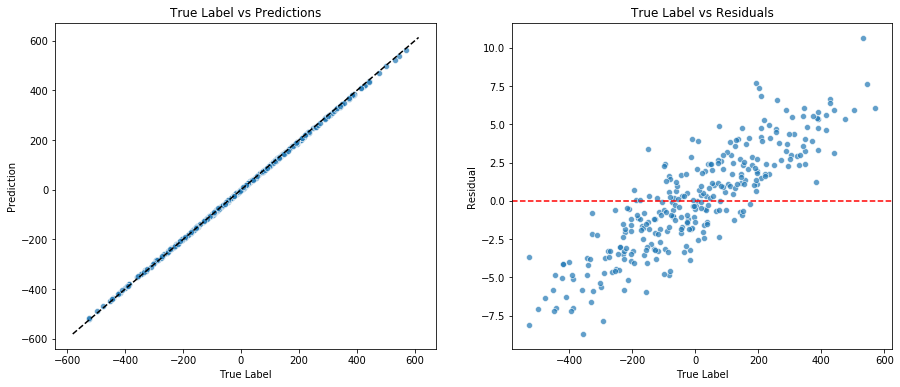

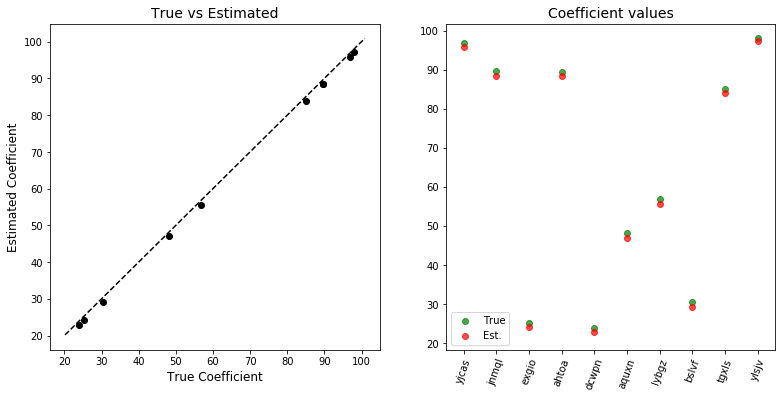

MAE: 		 2.76875
MSE: 		 11.66791
Max Error: 	 10.66143
Expl Variance: 	 0.99977


In [25]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

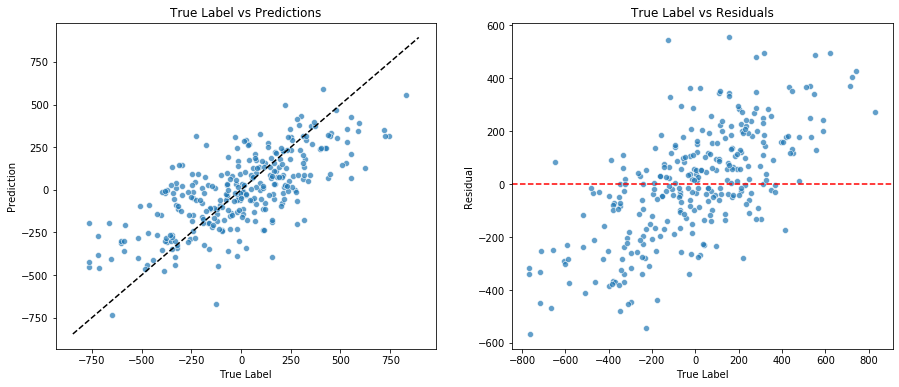

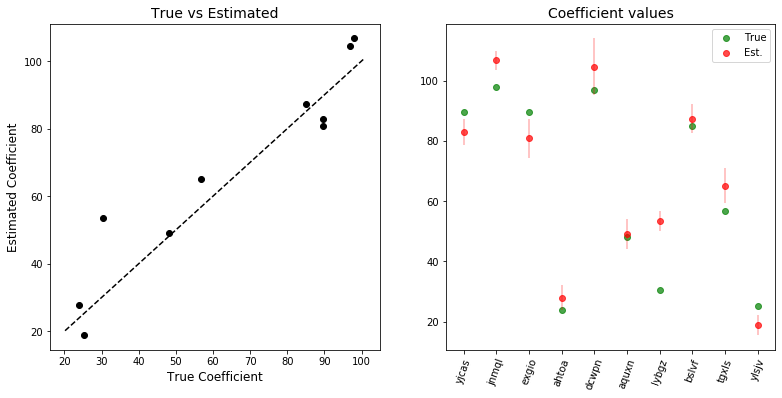

MAE: 		 165.8602
MSE: 		 44649.81727
Max Error: 	 566.16614
Expl Variance: 	 0.50491


In [26]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations.

## 100 features

As in the previous examples, the speed of the model is much higher (thanks to the better implementation) and we can again observe that the regularizing term is not influencing the ability of the model to be close to the best achievable result already with 9000 training samples.

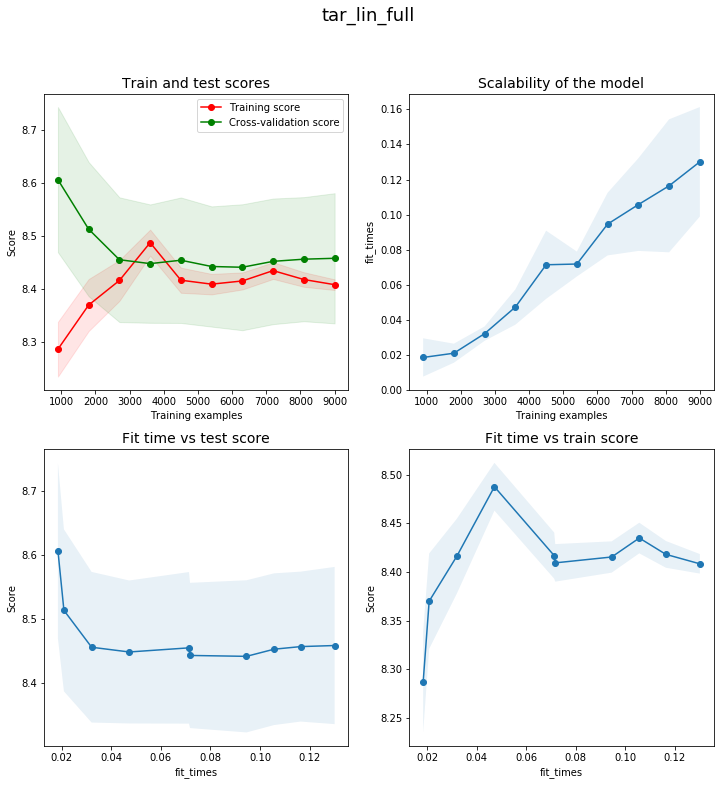

In [27]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

When using all the features, we can see how the model is setting to 0 several coefficients, regardless of their magnitude

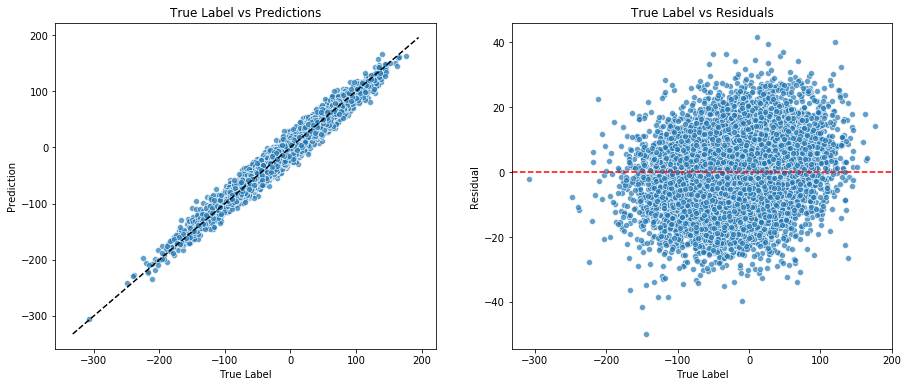

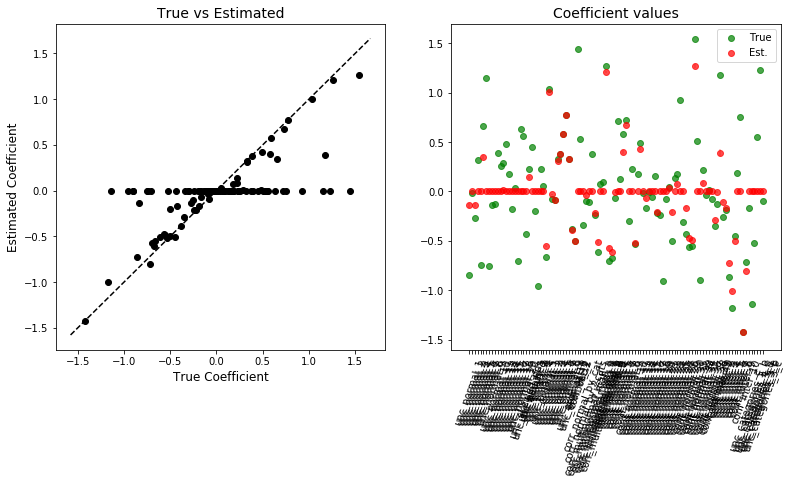

MAE: 		 8.47707
MSE: 		 113.72748
Max Error: 	 49.8527
Expl Variance: 	 0.96545


In [28]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

As a consequence, the model is performing worse than before.

On the other hand, when reducing the number of training instances the drop in performance is much smaller than before.

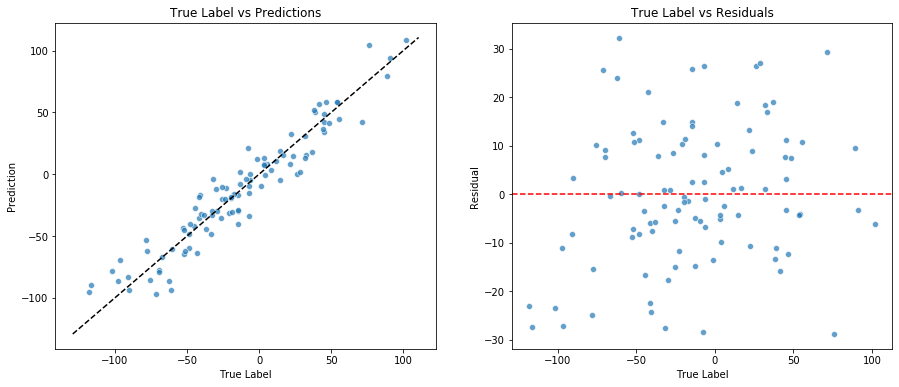

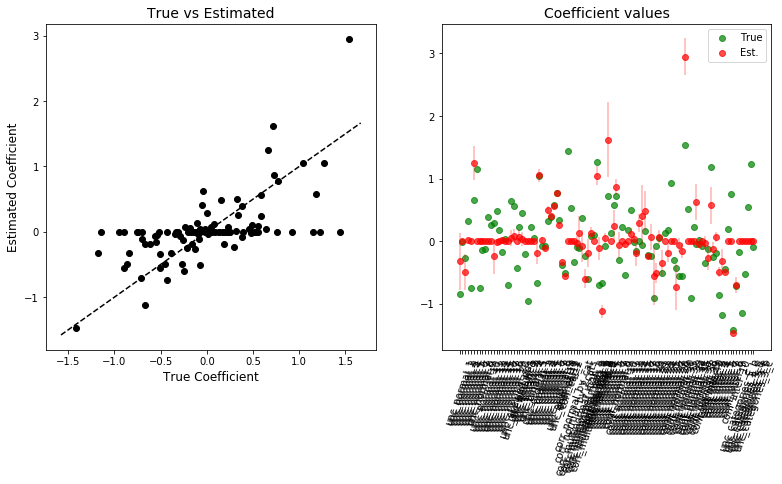

MAE: 		 11.42017
MSE: 		 203.96788
Max Error: 	 32.32198
Expl Variance: 	 0.90786


In [29]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This suggests that **the regularization is somewhat helping** and we indeed see that increasing it leads to a better performing model. This can be seen in the following plot.

{'lasso__alpha': 2.45}


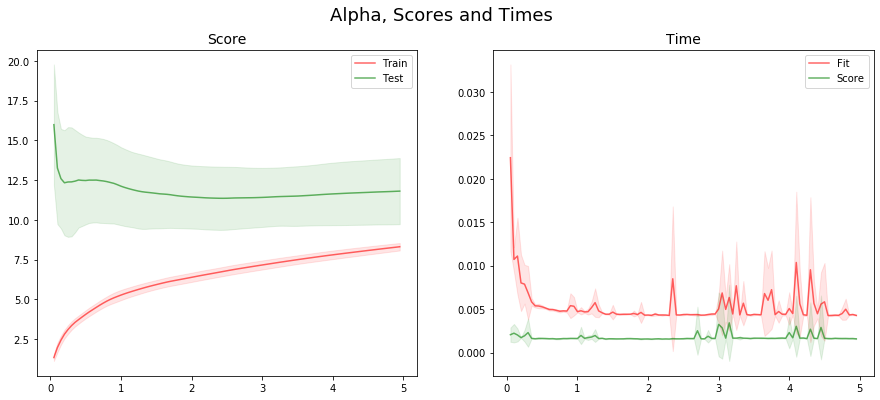

In [30]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', sample=100)

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

And we can indeed see a better perfoming model already with `alpha=2.5`

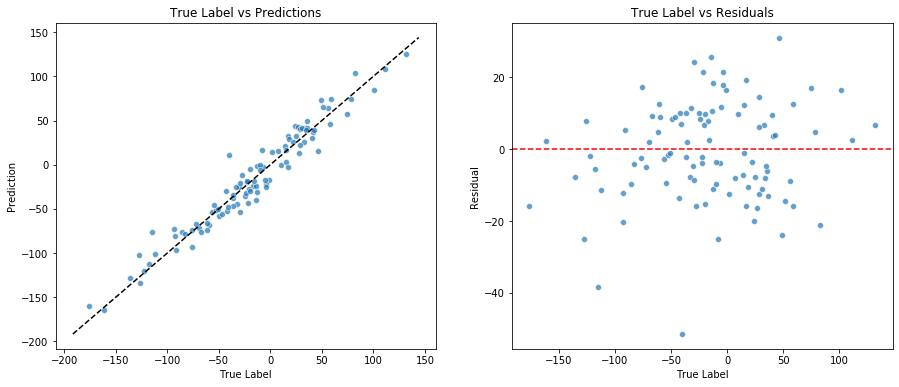

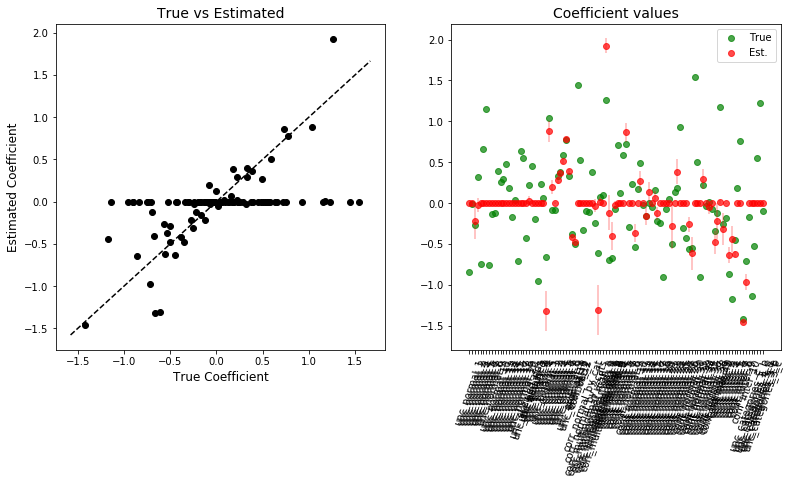

MAE: 		 11.13861
MSE: 		 190.49725
Max Error: 	 51.43387
Expl Variance: 	 0.94435


In [31]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2.5, random_state=325))])
params = {'alpha': 2.5}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Since we are curious about what would happen if all the coefficients were forced to be positive, we can see how bad the model gets in the next experiment.

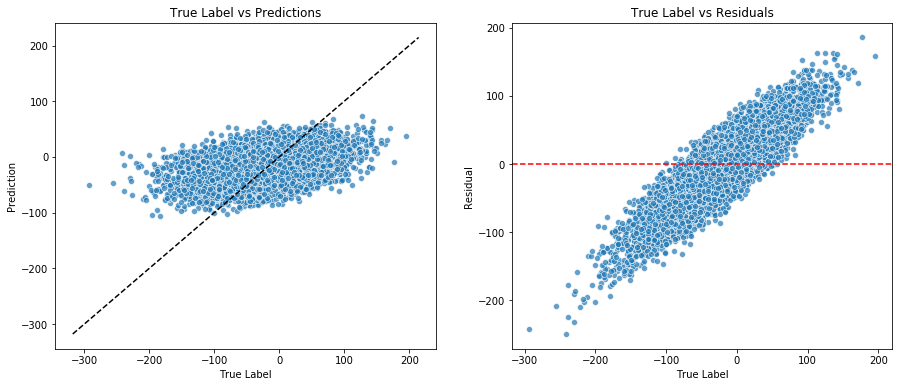

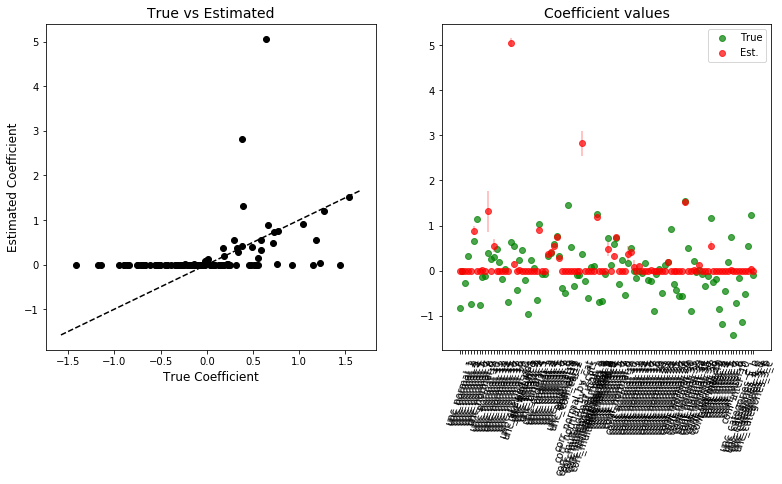

MAE: 		 40.29527
MSE: 		 2612.24061
Max Error: 	 249.61914
Expl Variance: 	 0.2077


In [34]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.5, positive=True, random_state=325))])
params = {'alpha': 0.5, 'positive': 'True'}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

In the presence of **unobserved variables**, however, the model struggles but not significantly more than before.

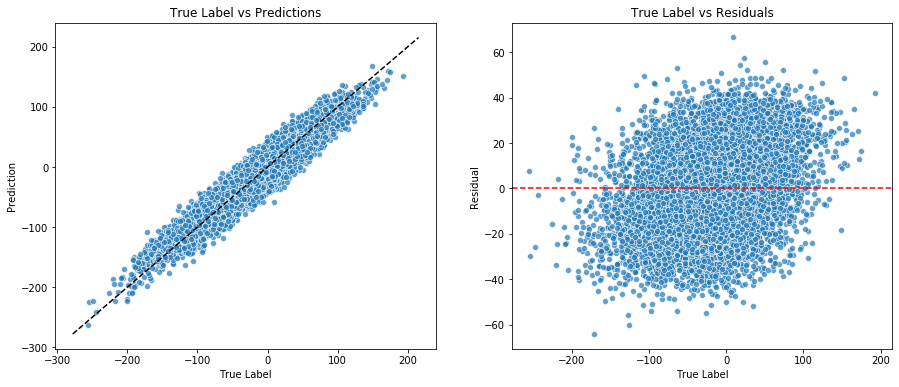

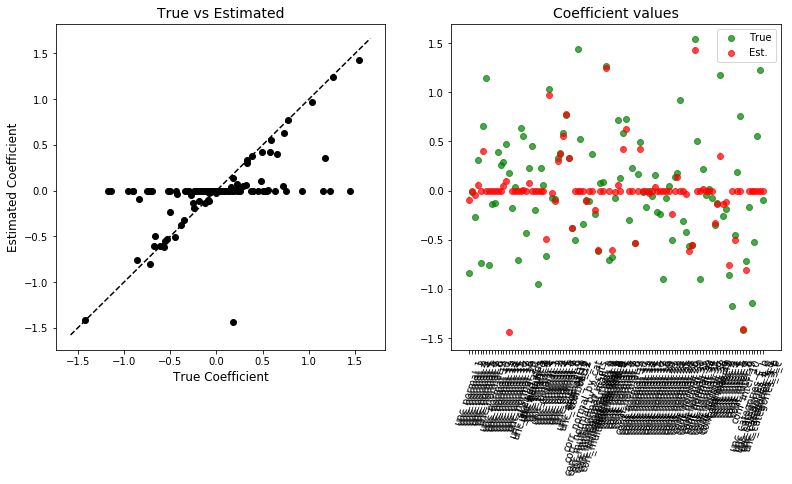

MAE: 		 15.87718
MSE: 		 366.96051
Max Error: 	 66.55655
Expl Variance: 	 0.88919


In [35]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 50 features

Let's now turn our attention to a situation where only 50 features of the 100 available have been used to generate the target

In [36]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

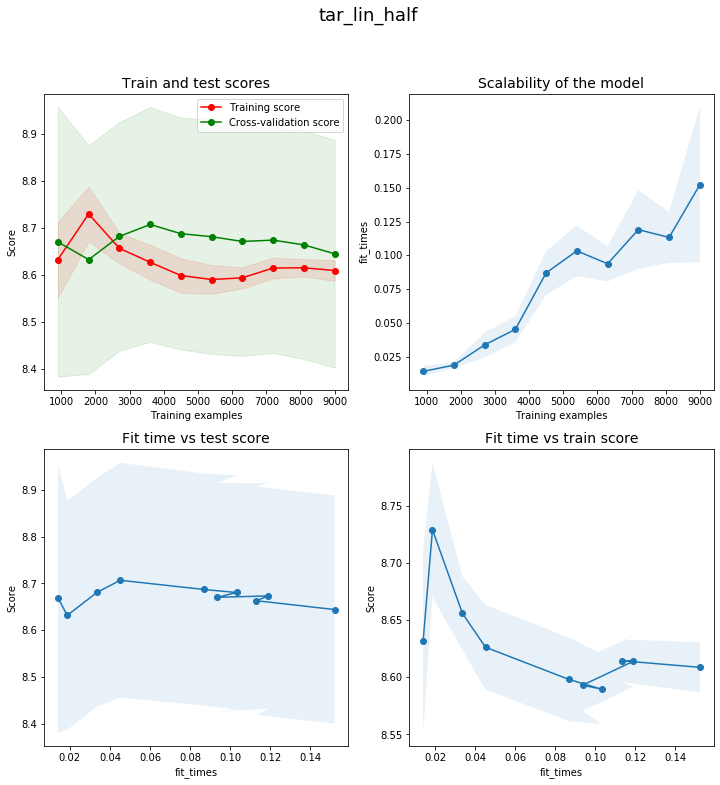

In [37]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

We can again appreciate how faster and more accurate the model becomes when we use the exact features we need to predict the target (remember that it roughly scales with the square of the number of features). Moreover, the model is now showing a more standard learning curve.

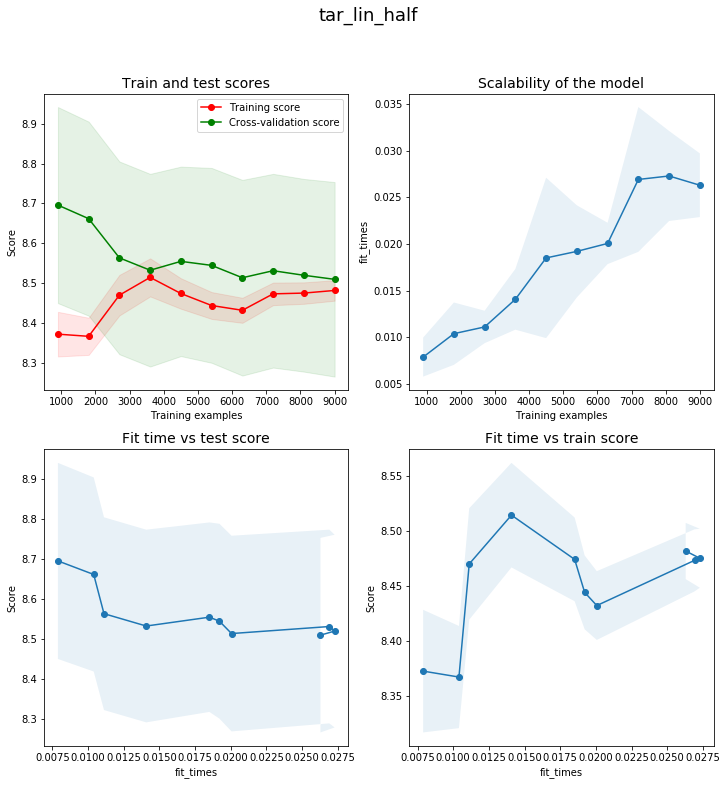

In [38]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We can thus use this as baseline for the next set of experiments. The performance is nearly identical with or without the regularization

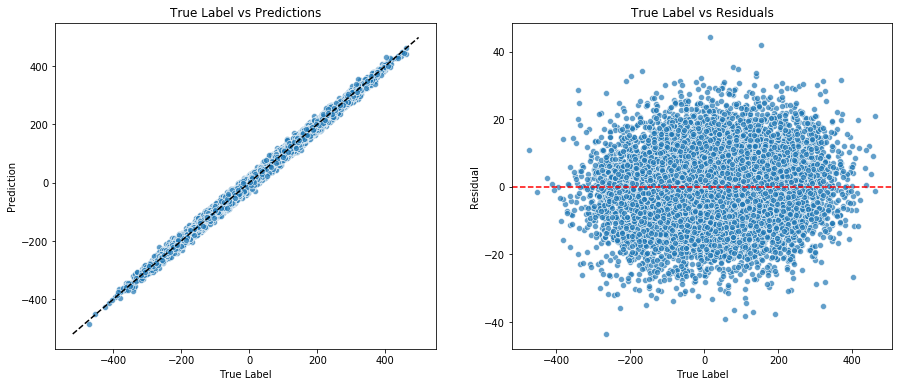

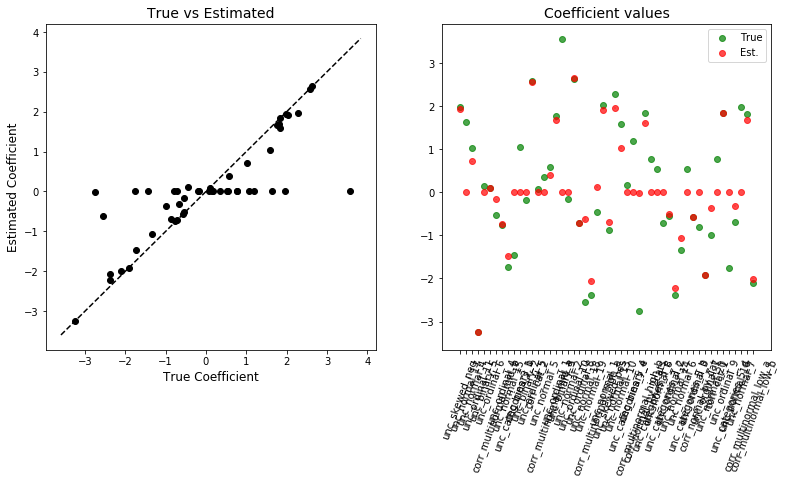

MAE: 		 8.45657
MSE: 		 113.08444
Max Error: 	 44.21297
Expl Variance: 	 0.9948


In [39]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Predictably, reducing the number of training instances leads to a worse performing model but, this time, it is performing better than its non-regularized counterpart

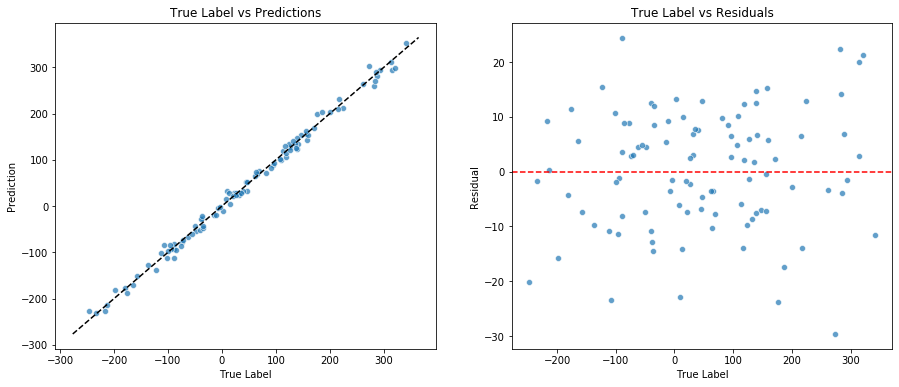

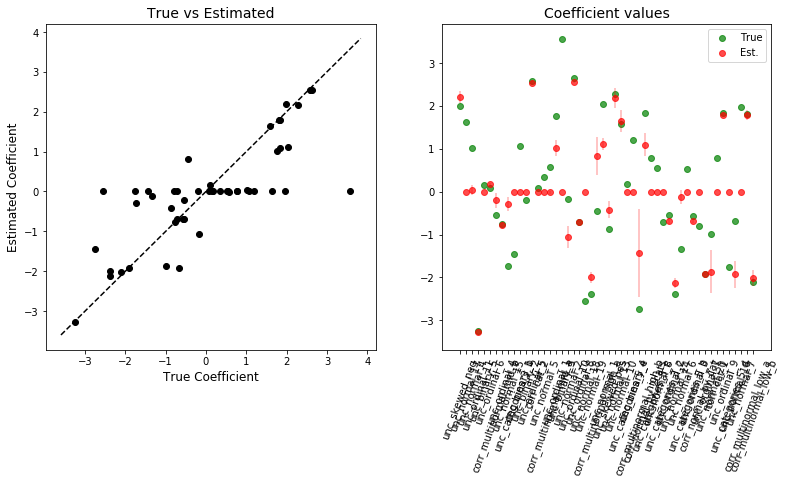

MAE: 		 8.86066
MSE: 		 116.19388
Max Error: 	 29.62536
Expl Variance: 	 0.99416


In [40]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can again search of the best configuration

{'lasso__alpha': 0.6000000000000001}


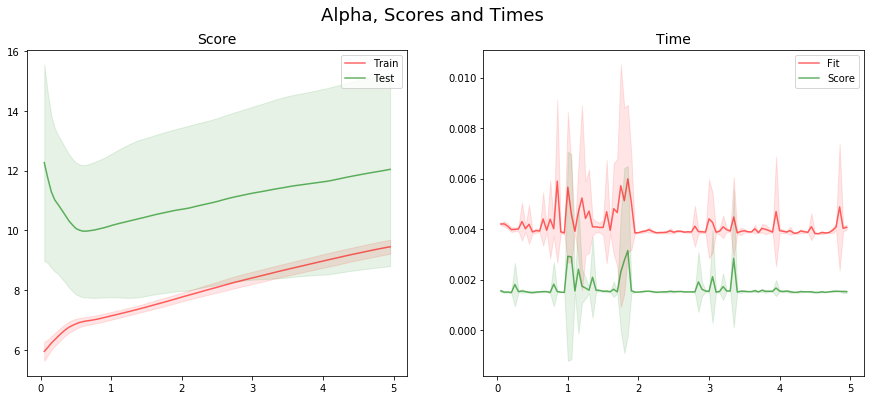

In [41]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100, features='exact')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

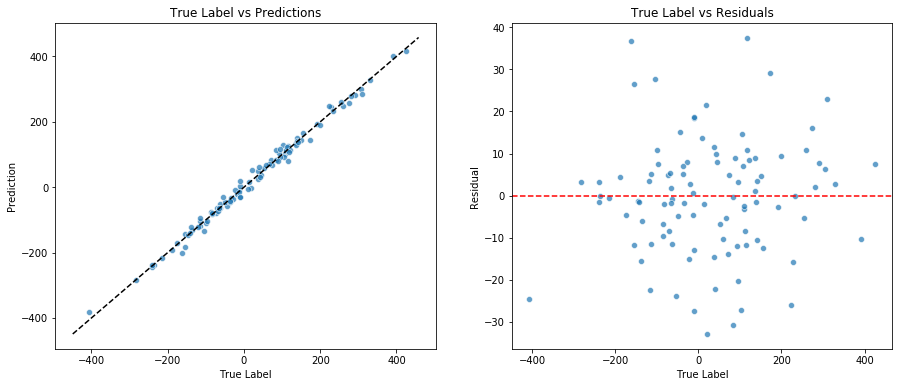

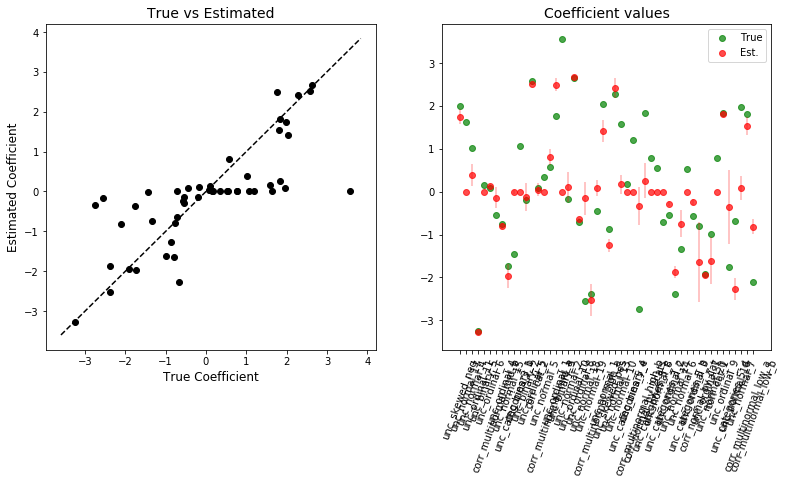

MAE: 		 10.50692
MSE: 		 189.80371
Max Error: 	 37.55652
Expl Variance: 	 0.99202


In [42]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=0.6, random_state=325))])
params = {'alpha': 0.6}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Which is not really better than before, teaching us the valuable lesson that **tuning your model for a small improvement can do more harm than good**. Especially if the uncertainty is so large.

Training the model on more features than necessary doesn't seem to influence the performance or the coefficients' estimates much.

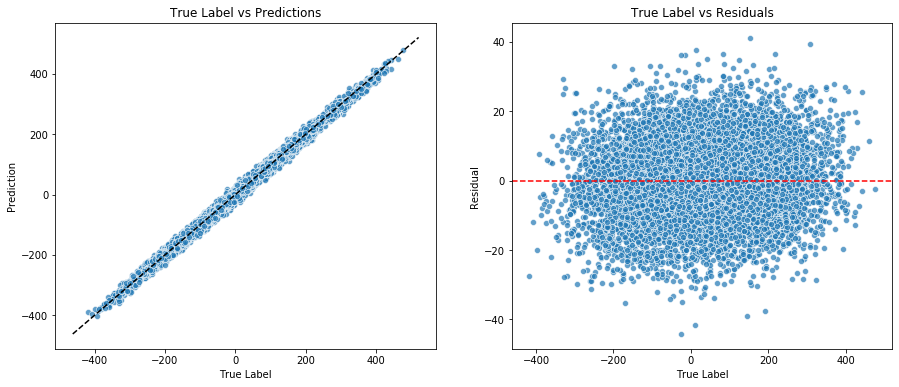

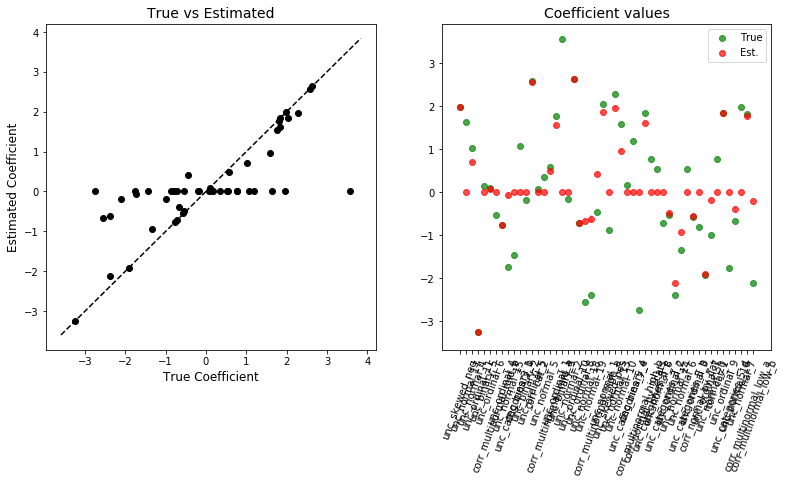

MAE: 		 8.69538
MSE: 		 117.95175
Max Error: 	 44.16075
Expl Variance: 	 0.99454


In [43]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

But again the drop in performance that one expects when the number of training instances is reduced is somewhat smaller thanks to the regularization. The reason is that the model is not giving too much importance to one feature due to the limited sample thanks to the fact that the magnitude of the coefficients is regularized by the term *alpha*.

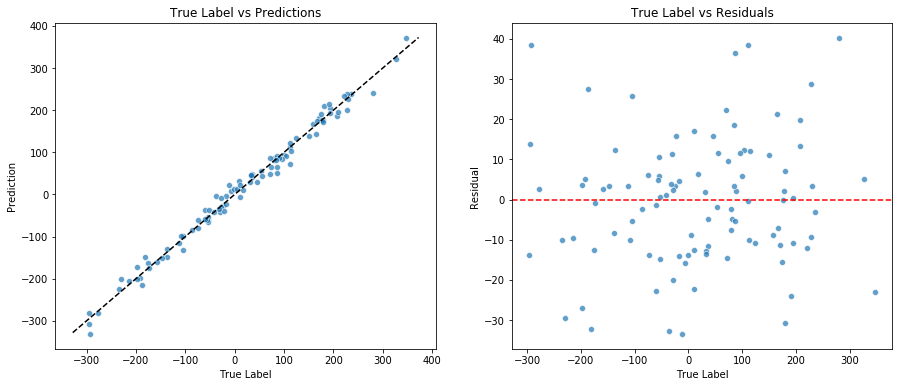

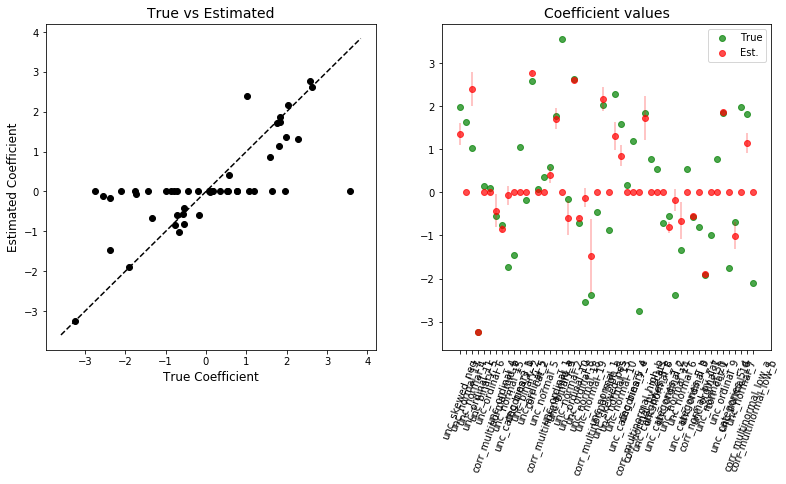

MAE: 		 12.31177
MSE: 		 248.01803
Max Error: 	 40.3109
Expl Variance: 	 0.98831


In [67]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

{'lasso__alpha': 2.0}


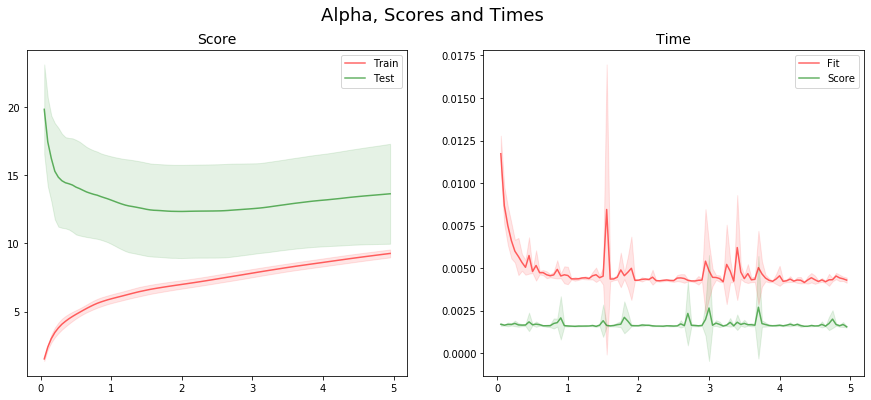

In [69]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

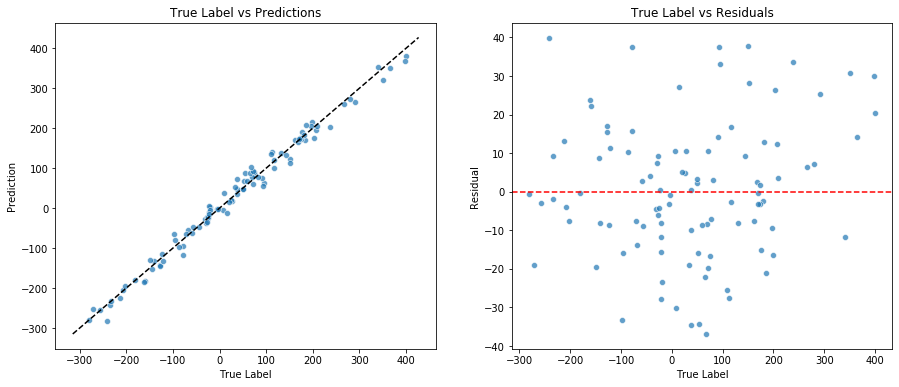

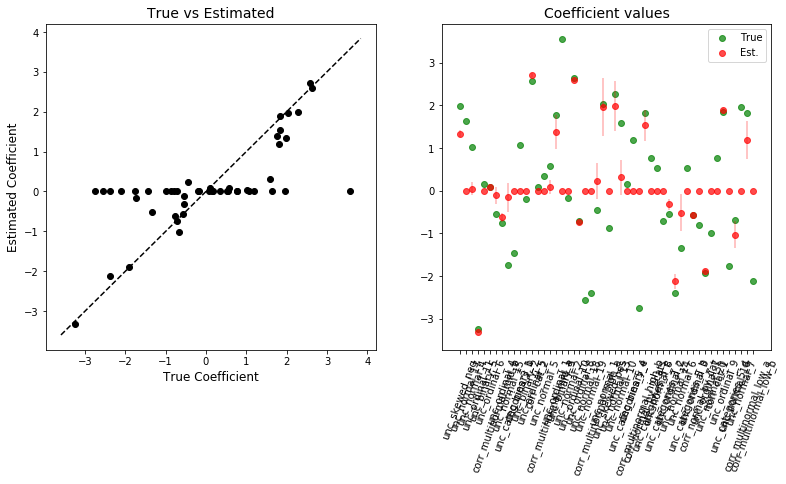

MAE: 		 14.04601
MSE: 		 312.99441
Max Error: 	 39.96445
Expl Variance: 	 0.98688


In [70]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2, random_state=325))])
params = {'alpha': 2}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We indeed improved the performance and the coefficients' estimates are less all over the place. Intuitively, it makes sense that the regularization is helping now as it should help handling better features that are not supposed to be important for predicting the target (and in this case half of the features are not relevant).

On the other hand, when it is a certain number of features missing, the regularization does not seem to help much.

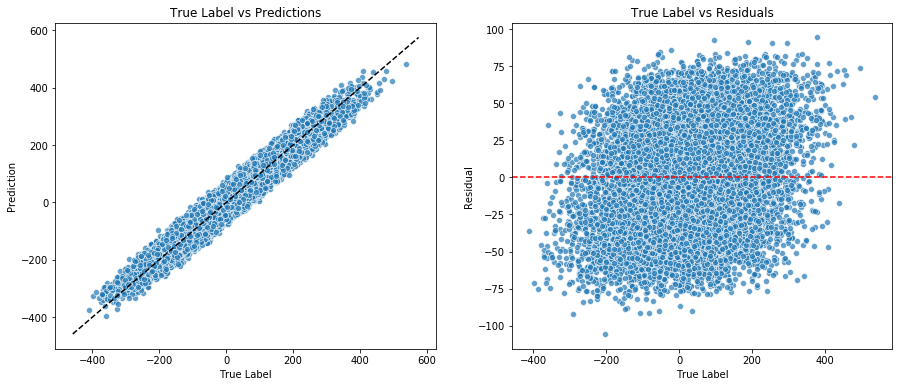

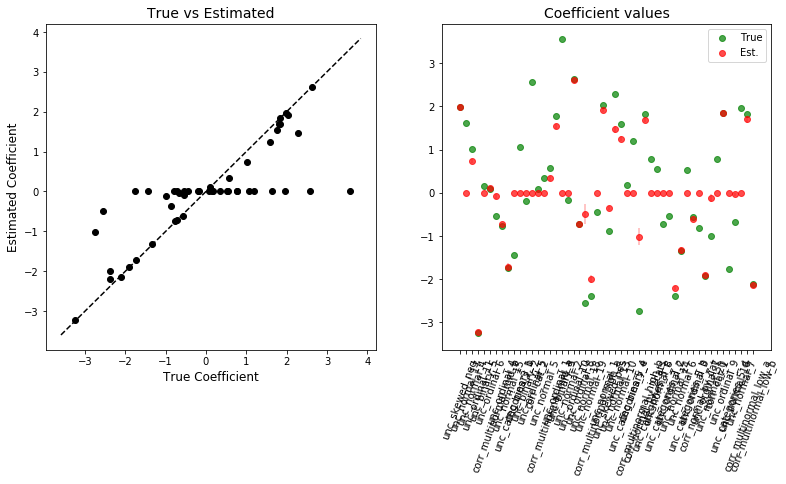

MAE: 		 32.4747
MSE: 		 1451.36867
Max Error: 	 105.69842
Expl Variance: 	 0.93181


In [71]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

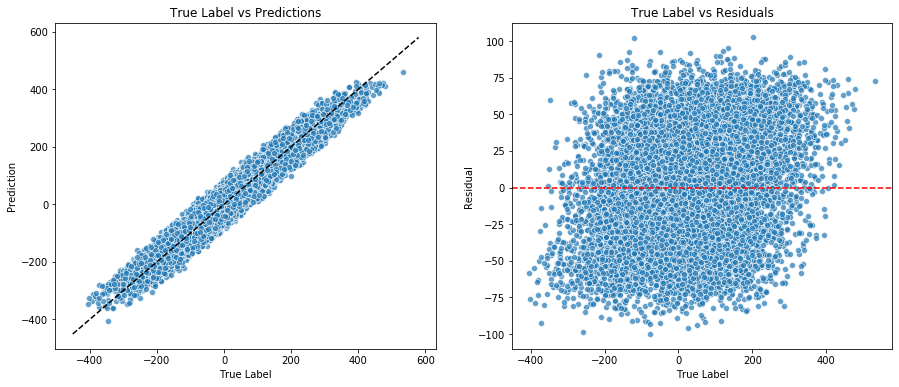

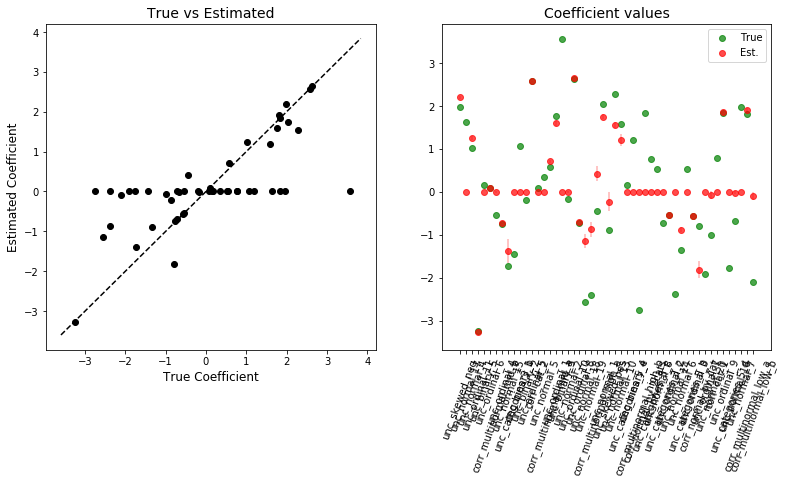

MAE: 		 34.11578
MSE: 		 1599.38158
Max Error: 	 102.45987
Expl Variance: 	 0.92674


In [72]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 10 features

We have already seen how easy it is for the model to pick up the signal from the data. Introducing a regularization term is helping in slighly improving the metrics.

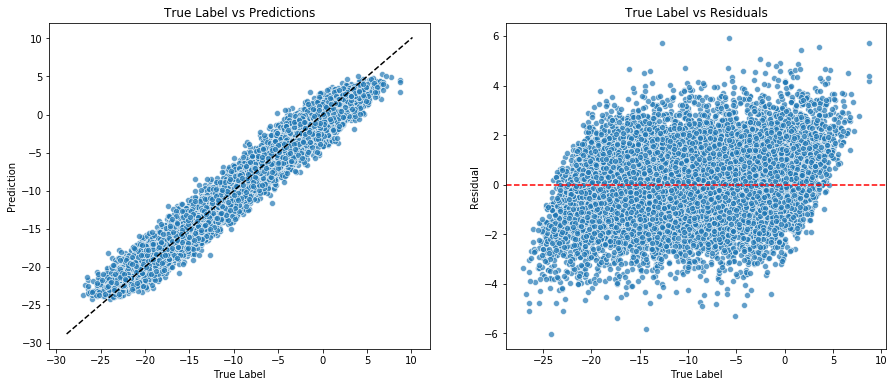

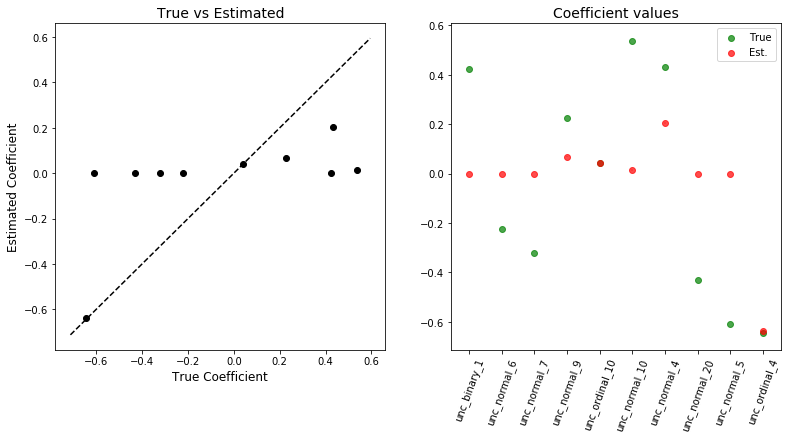

MAE: 		 1.24681
MSE: 		 2.42881
Max Error: 	 6.01147
Expl Variance: 	 0.95809


In [73]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can also see how the performance gets worse if we reduce the training instances to 100. In particular, we see 2 coefficients wrongly estimated quite significantly.

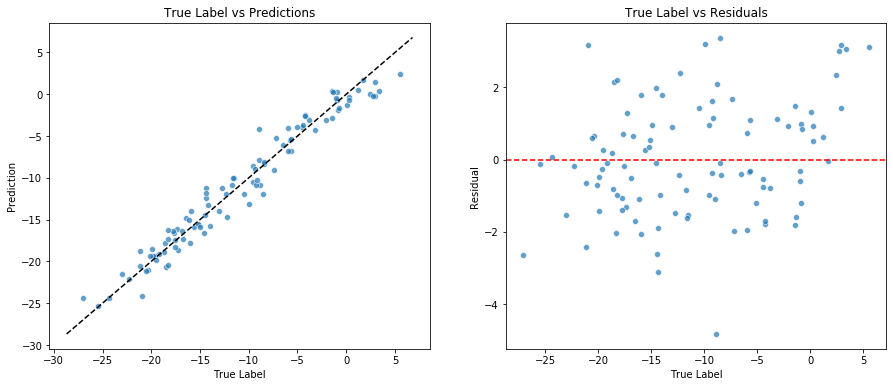

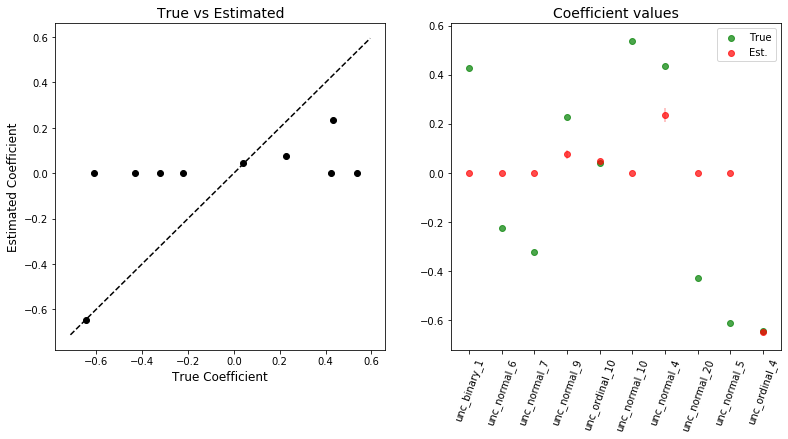

MAE: 		 1.28235
MSE: 		 2.50218
Max Error: 	 4.8138
Expl Variance: 	 0.95911


In [74]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

On the other hand, using more features or fewer features than necessary doesn't seem to compromise the model behavior much.

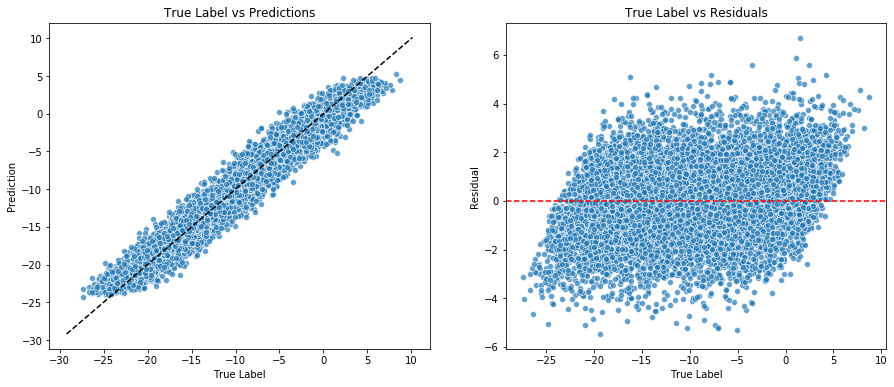

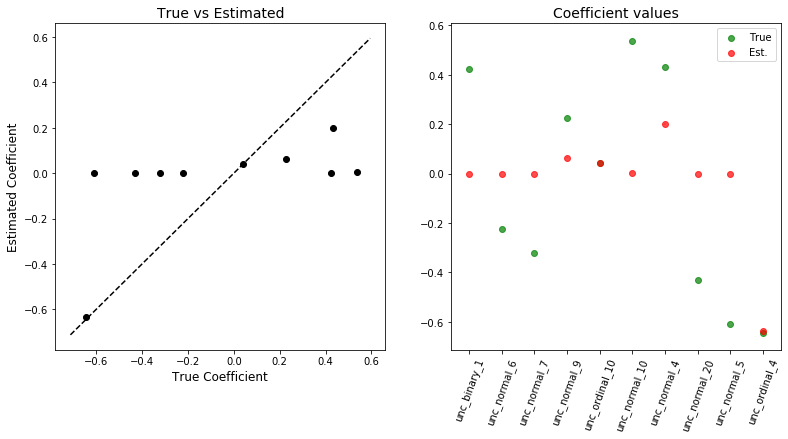

MAE: 		 1.25017
MSE: 		 2.4582
Max Error: 	 6.70463
Expl Variance: 	 0.95712


In [75]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

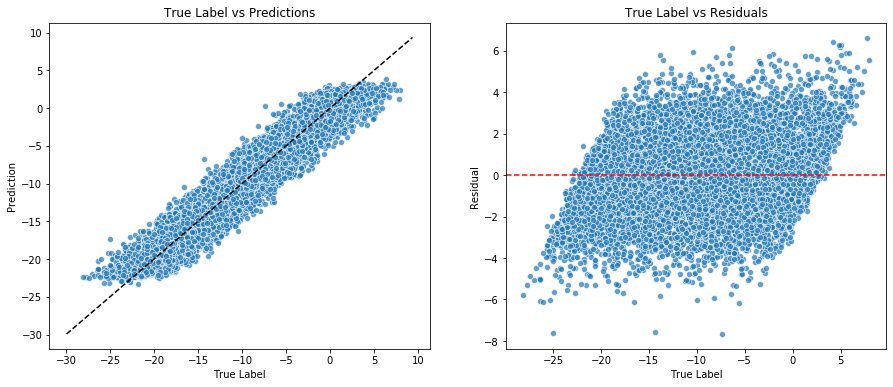

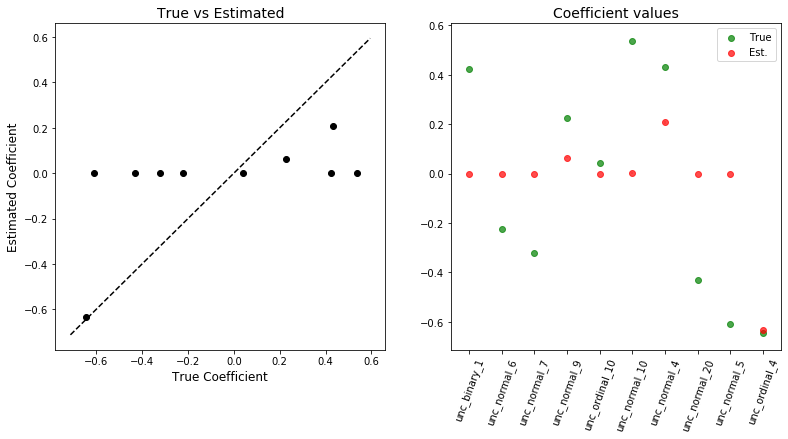

MAE: 		 1.58251
MSE: 		 3.84372
Max Error: 	 7.65305
Expl Variance: 	 0.93144


In [76]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

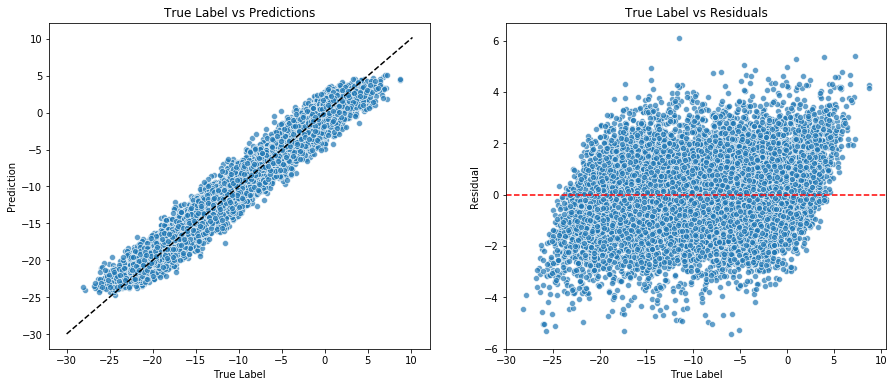

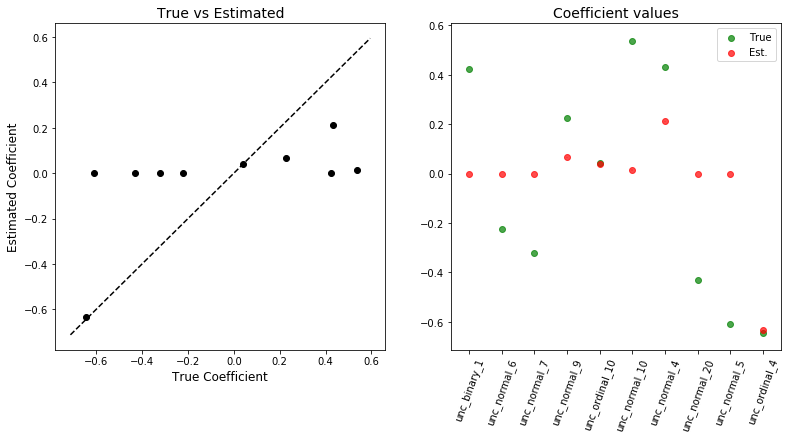

MAE: 		 1.23772
MSE: 		 2.41531
Max Error: 	 6.1121
Expl Variance: 	 0.95807


In [77]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## Non-linear relations

Using a target generated non-linearly we expect the model to struggle in finding the right signal. As we have seen in notebook 3, it is not the case but introducing the regularization is slightly improving the evaluation metrics.

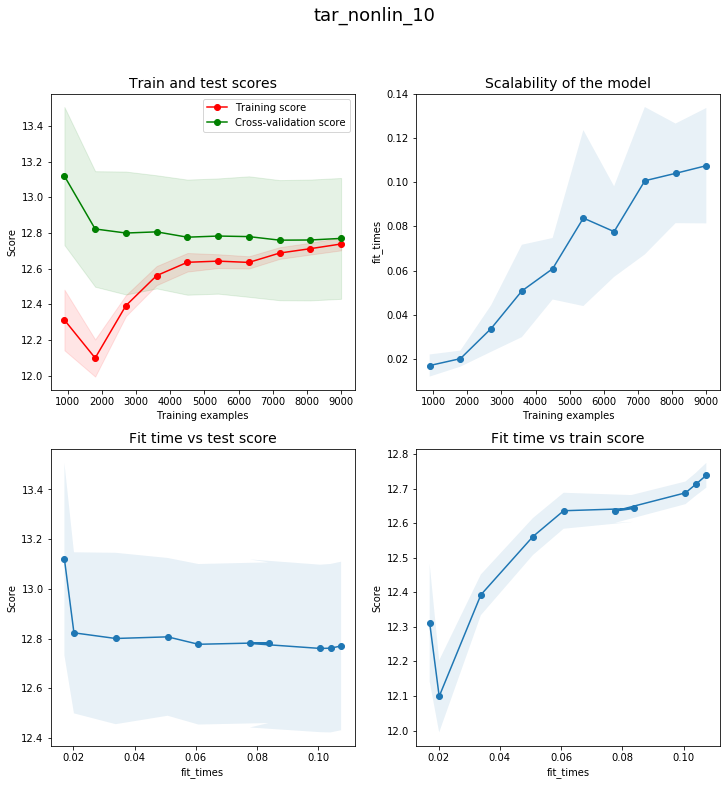

In [78]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

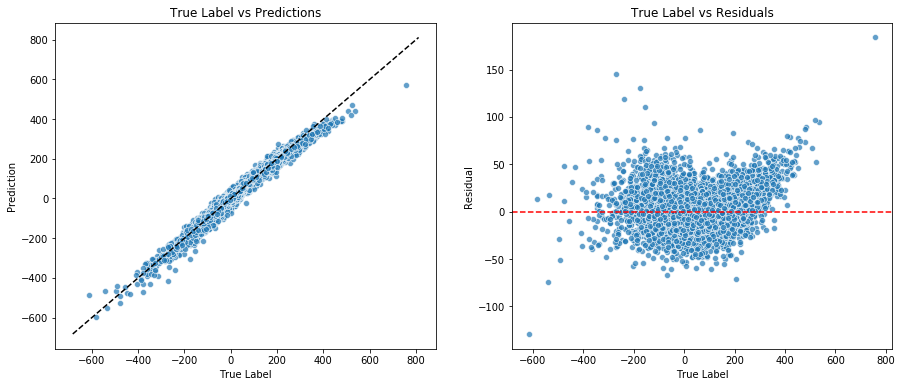

MAE: 		 12.73226
MSE: 		 302.78865
Max Error: 	 183.7948
Expl Variance: 	 0.97971


In [45]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

Once again, reducing the number of observations leads to a worse performance but, once again, it is this the situation where the regularization is helpful the most

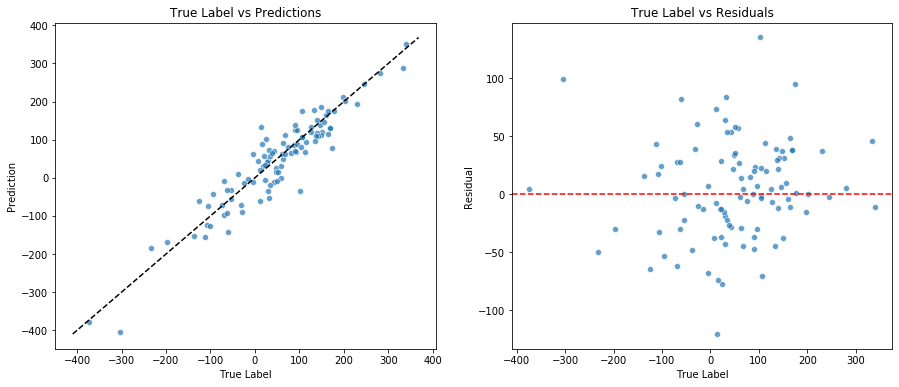

MAE: 		 33.05181
MSE: 		 1805.65085
Max Error: 	 135.23519
Expl Variance: 	 0.86882


In [46]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

{'lasso__alpha': 2.65}


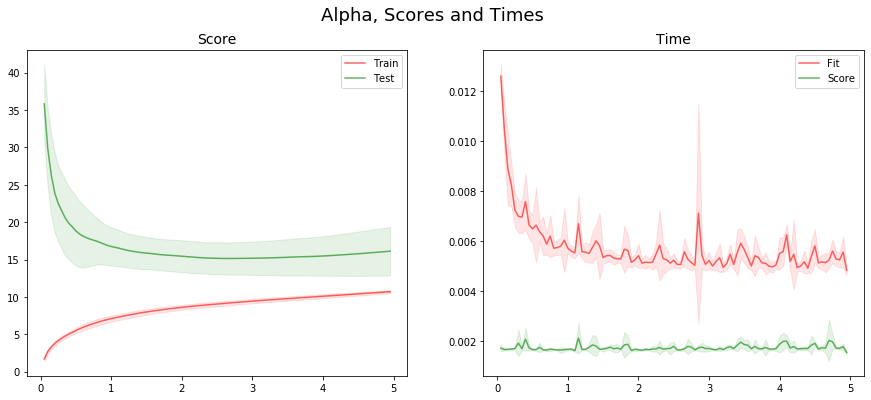

In [80]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=1, random_state=325))])

param_grid = {'lasso__alpha': list(np.arange(0.05, 5, 0.05))}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_lasso__alpha', 'Alpha')

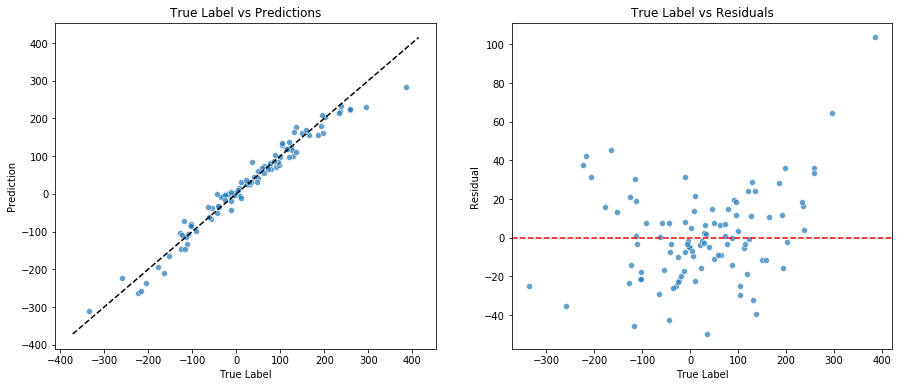

MAE: 		 17.5632
MSE: 		 552.8837
Max Error: 	 103.51807
Expl Variance: 	 0.9654


In [81]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('lasso', Lasso(alpha=2.5, random_state=325))])
params = {'alpha': 2.5}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

# Real application - HousePrice

It is finally time to test the performance of this algorithm on the dataset of the House Price competition. As before, we use a generic pipeline [developed in this notebook](https://www.kaggle.com/lucabasa/houseprice-end-to-end-project). 

In the unregularized Linear Regression example of notebook 3 we have seen how some coefficients were estimated with very large uncertainty from fold to fold. We expect the regularization to help in this case.

First, let's see how the model is influenced by the choice of hyperparameters

In [93]:
model = ('lasso', Lasso())
params = {'alpha':1}

param_grid = {'lasso__alpha': list(np.arange(0.01, 0.4, 0.01)), 
              'lasso__tol': np.arange(0.0001, 0.001, 0.0001), 
              'lasso__selection': ['cyclic', 'random'], 
              'lasso__positive': [True, False]}

res = grid_results(model, kfolds, param_grid, hp=True)

res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'lasso__alpha': 0.01, 'lasso__positive': True, 'lasso__selection': 'random', 'lasso__tol': 0.0008}


param_lasso__alpha param_lasso__positive param_lasso__selection  \
0               0.01                  True                 random   
1               0.01                  True                 cyclic   
2               0.01                  True                 cyclic   
3               0.01                  True                 random   
4               0.01                  True                 cyclic   

  param_lasso__tol  mean_train_score  std_train_score  mean_test_score  \
0           0.0008         -0.090504         0.000829        -0.092205   
1           0.0001         -0.090501         0.000824        -0.092206   
2           0.0002         -0.090503         0.000825        -0.092207   
3           0.0001         -0.090502         0.000824        -0.092207   
4           0.0003         -0.090505         0.000824        -0.092208   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.007069       0.195973      0.008365         0.120551   
1        0.007072       0.180162      0.019815         0.103292   
2        0.007070       0.165826      0.004058         0.098990   
3        0.007074       0.180011      0.016976         0.108355   
4        0.007070       0.164825      0.002865         0.099064   

   std_score_time  
0        0.008302  
1        0.007762  
2        0.001258  
3        0.009995  
4        0.001919

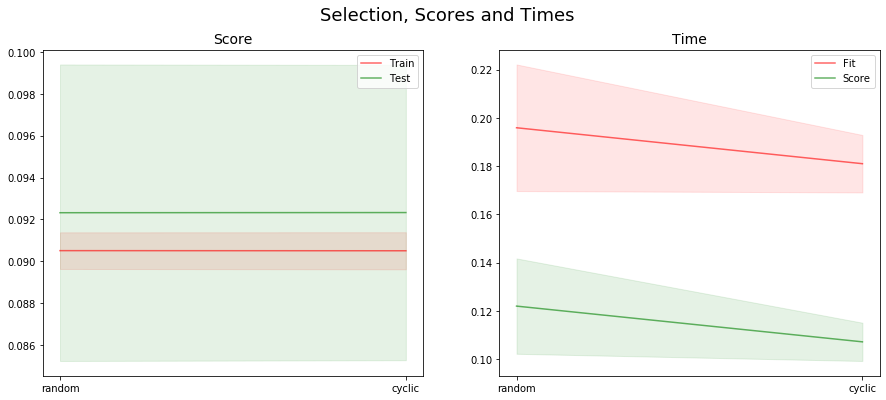

In [95]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.01) & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__positive==False)], 'param_lasso__selection', 'Selection')

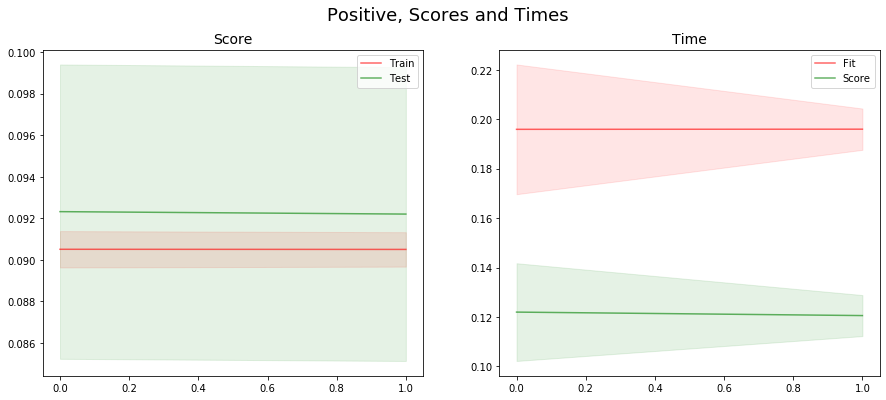

In [96]:
hyp.plot_hyperparameter(res[(res.param_lasso__alpha == 0.01) & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__selection=='random')], 'param_lasso__positive', 'Positive')

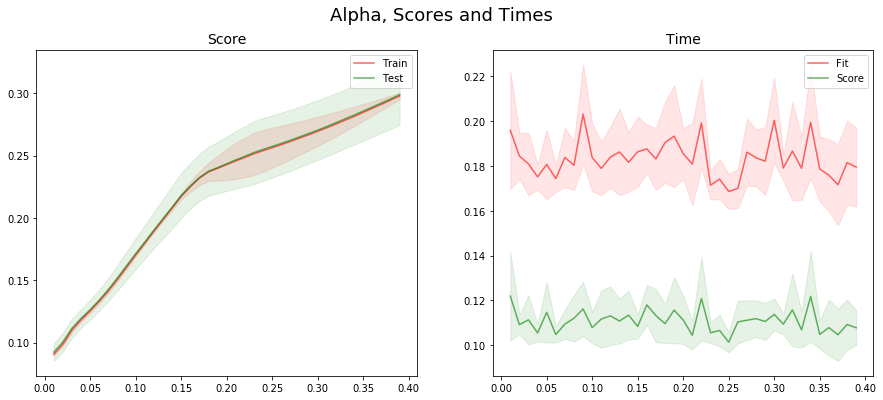

In [97]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__tol==0.0008) & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'Alpha')

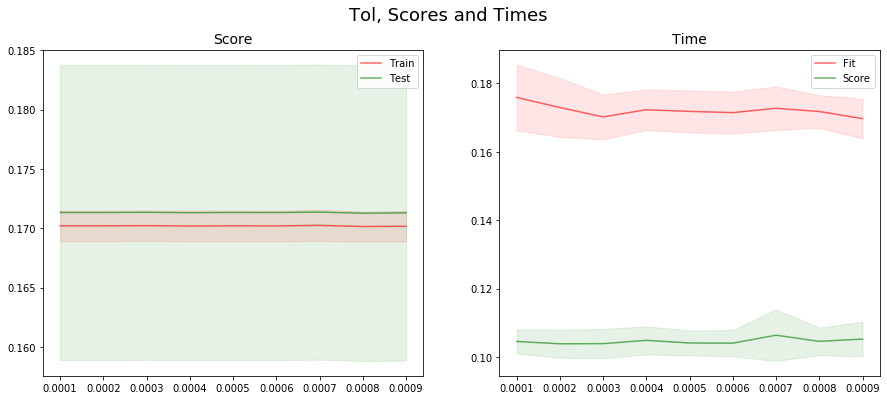

In [90]:
hyp.plot_hyperparameter(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__alpha==0.1) & 
                            (res.param_lasso__positive==False)], 'param_lasso__tol', 'Tol')

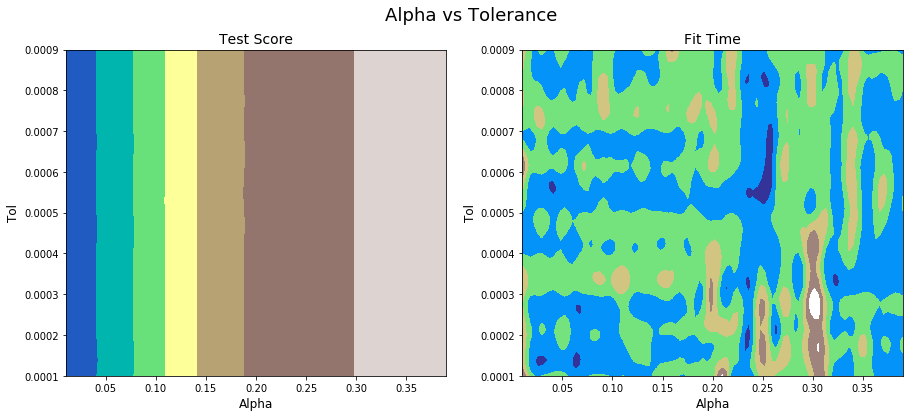

In [98]:
hyp.plot_two_hyperparms(res[(res.param_lasso__selection == 'random') & 
                            (res.param_lasso__positive==False)], 'param_lasso__alpha', 'param_lasso__tol', 'Alpha vs Tolerance')

We finally see some more interesting patterns, some regularization seems to help but it then stops being helpful. Moreover, at the sweet spot for the hyperparameter `alpha,` we see that playing around with `tol` can improve or worsen the performance of the model. On the other hand, once that `alpha` is away from this spot, this hyperparameter stops being relevant.

We indeed see that adding a small regularizing term leads to a model that not only performs slightly better (to be fair, it is an improvement at the third digit of each metric) but, most importantly, helps the model estimating the coefficients with less uncertainty.

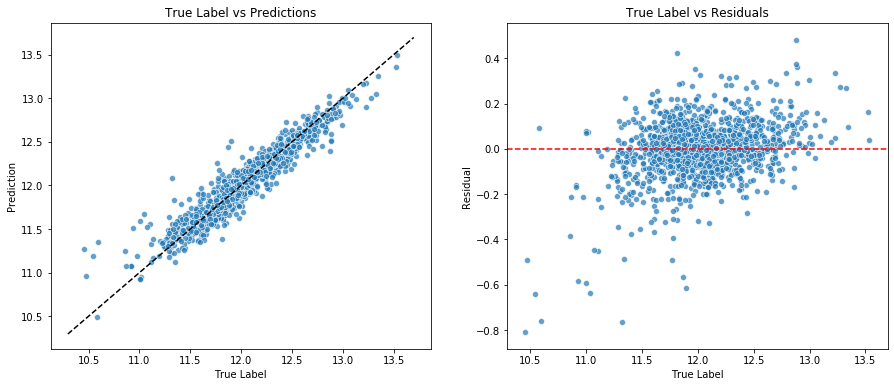

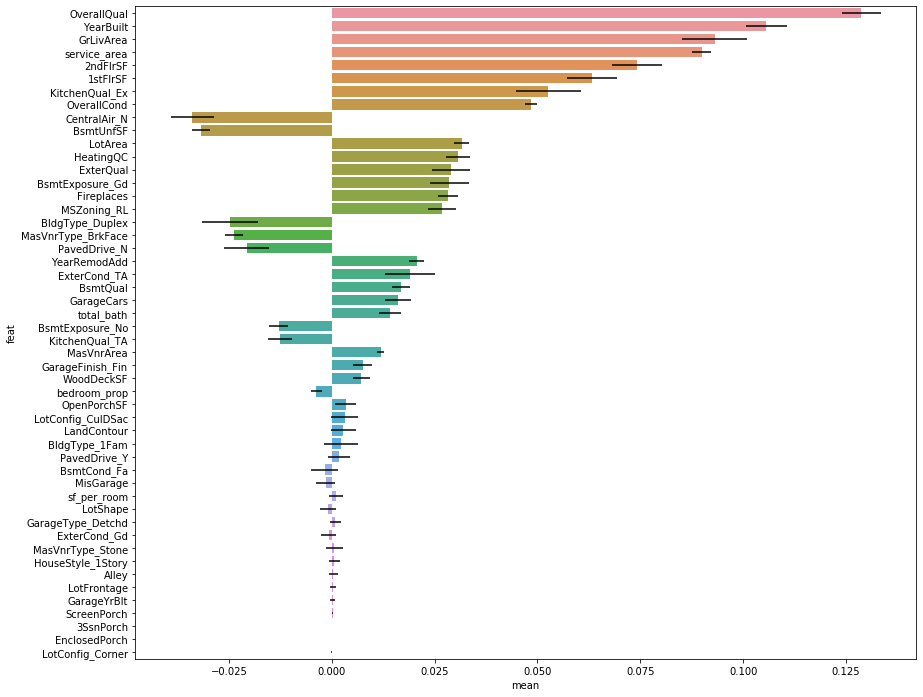

MAE: 		 0.08401
MSE: 		 0.01461
Max Error: 	 0.80737
Expl Variance: 	 0.90846


In [100]:
model = ('lasso', Lasso(alpha=0.001))
params = {'alpha':0.001}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

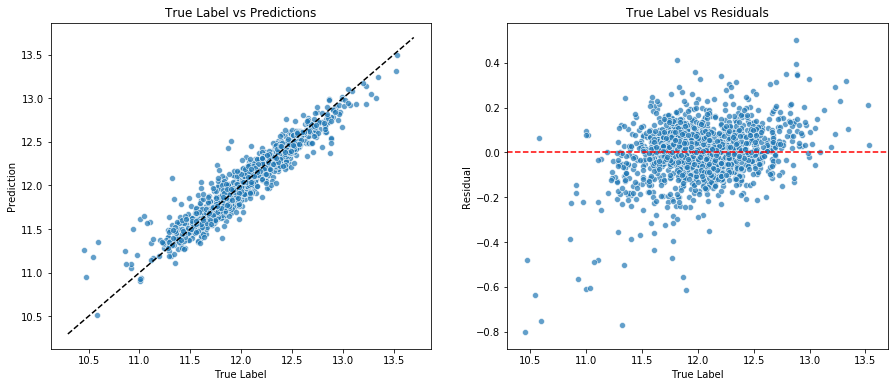

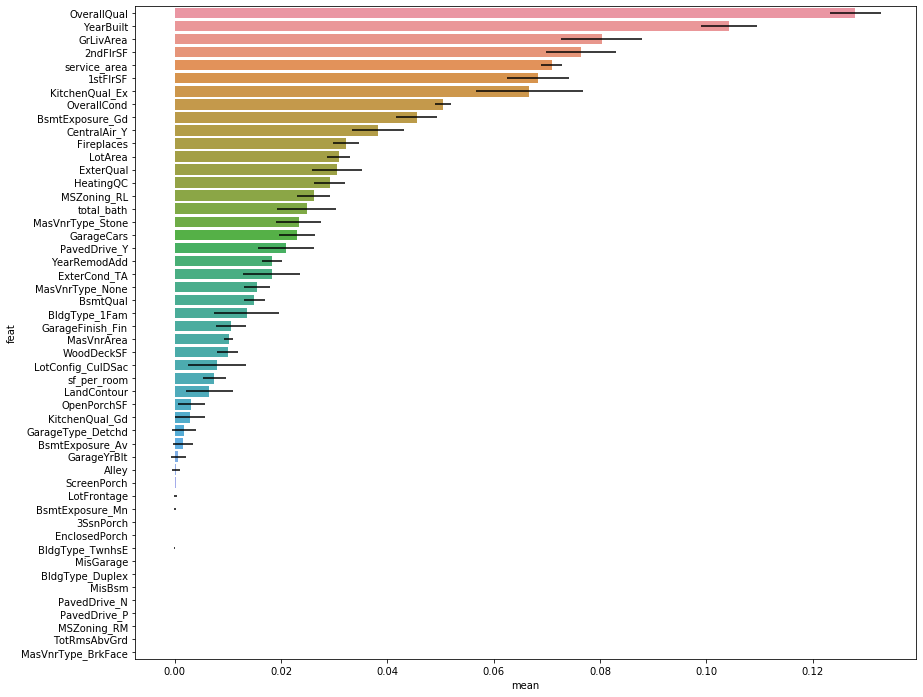

MAE: 		 0.08622
MSE: 		 0.01507
Max Error: 	 0.80063
Expl Variance: 	 0.90564


In [104]:
model = ('lasso', Lasso(alpha=0.001, positive=True))
params = {'alpha':0.001, 'positive':'True'}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

It has to be noticed that some coefficients are not as interpretable as we would like to. For example `ExterCond_Gd` has a negative coefficient, while `ExterCond_TA` has a positive one, which is not what one would expect.

If we then set the model to the optimal hypeparameters, we see an even lower uncertainty in the coefficients' estimates

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06509655625960775, tolerance: 0.02115031653224498
  positive)
/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0368666274098608, tolerance: 0.020590718641276717
  positive)


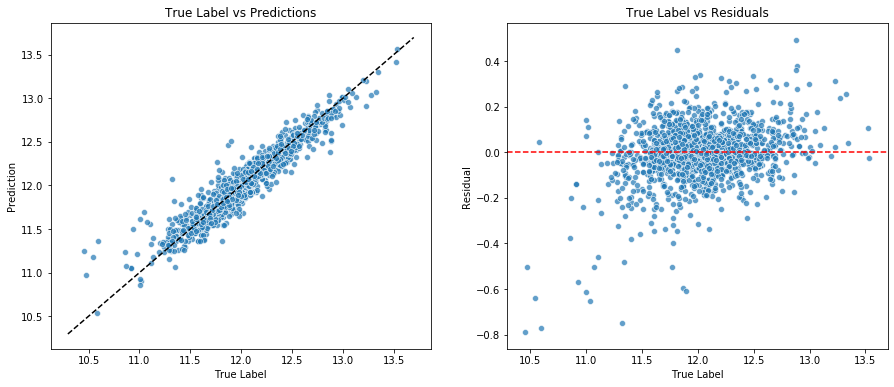

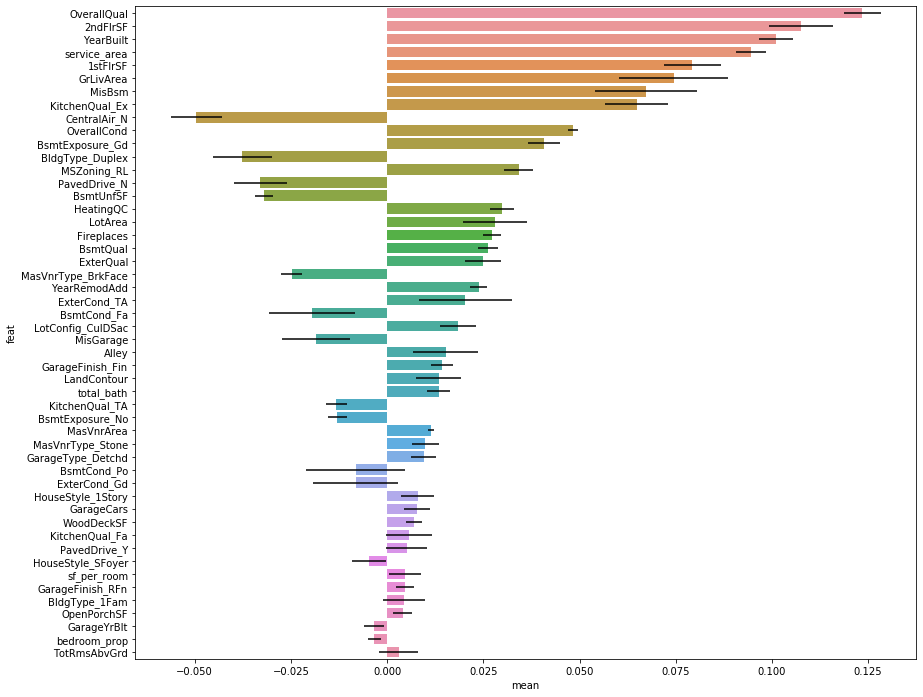

MAE: 		 0.08427
MSE: 		 0.01478
Max Error: 	 0.78693
Expl Variance: 	 0.9074


In [102]:
model = ('lasso', Lasso(alpha=0.0001))
params = {'alpa':0.0001}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

And bringing the regularization to an extreme value we indeed see smaller and smaller estimates with smaller and smaller uncertainties. This is indeed the effect of the $L_2$ regularization: making the coefficients smaller.

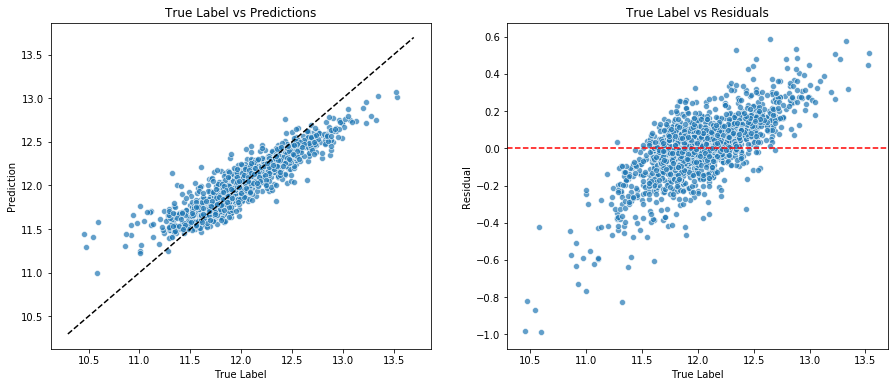

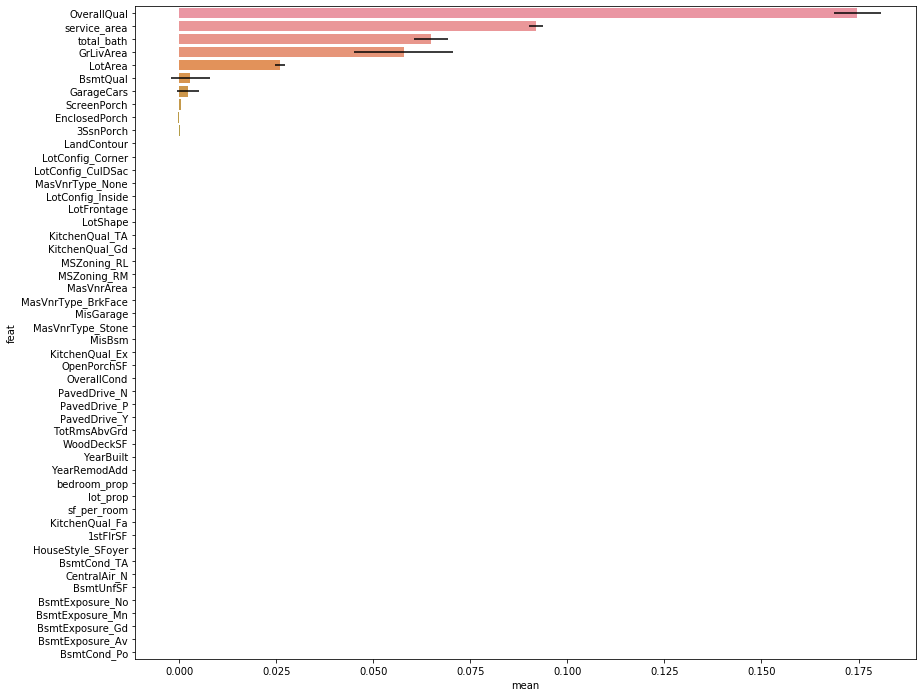

MAE: 		 0.12636
MSE: 		 0.03069
Max Error: 	 0.98824
Expl Variance: 	 0.80778


In [103]:
model = ('lasso', Lasso(alpha=0.05))
params = {'alpa':0.05}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name=modelname)

# Conclusion

We have seen how, with the synthetic data at hand, adding a regularizing term to our model is not generally helping. However, the regularization is becoming more important when the number of training instances is limited.

In general, the higher is the regularizing parameter, the less the model is learning the data. This can help the predictive power of a model that was previously focusing on the wrong things. The training or prediction times are not affected by the presence or the magnitude of the regularization.

The other hyperparameter (`tol`) had, at best, marginally influenced the model performance. Therefore, once that we find the right value for `alpha`, we can consider the model tuning phase as done. 

The summary of the models' results is the following

In [57]:
df = pd.read_csv(lab_book)
df = df[df.Model=='Ridge'].copy()
df.head()

Date  Model    Parameters                      Target Variables  \
24  14/02/2020  Ridge  {'alpha': 1}      10_feat_10_inf_nonoise       all   
25  14/02/2020  Ridge  {'alpha': 1}        10_feat_10_inf_noise       all   
26  14/02/2020  Ridge  {'alpha': 1}       100_feat_65_inf_noise       all   
27  14/02/2020  Ridge  {'alpha': 1}  100_feat_65_inf_noise_rank       all   
28  14/02/2020  Ridge  {'alpha': 1}      10_feat_10_inf_nonoise       all   

    N_instances         MAE            MSE    Max_error  Explained_var  
24       100000    0.001985       0.000006     0.010702       1.000000  
25       100000  159.159570   39903.463659   870.785668       0.553371  
26       100000  359.517907  202633.437357  1939.613873       0.489070  
27       100000    0.799542       1.003251     4.167692       0.265067  
28          300    0.703628       0.749763     2.785544       0.999985

In [58]:
df[df.Target == 'tar_lin_full']

Date  Model     Parameters        Target   Variables  N_instances  \
30  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full         all        10000   
31  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full         all          100   
32  14/02/2020  Ridge  {'alpha': 20}  tar_lin_full         all          100   
33  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full  unobserved        10000   

          MAE         MSE  Max_error  Explained_var  
30   8.036092  101.710207  41.837045       0.969162  
31  19.649853  637.478339  69.144850       0.786363  
32  11.966532  223.232365  39.403148       0.935380  
33  15.701427  359.678747  59.245463       0.893580

With a target generated linearly with 100 features we observe that

* Moving from 10000 to 100 observations leads to +144% in MAE, +526% in MSE, +65% in Max Error, and -18% in explained variance. This is a lower drop with respect to the unregularized experiment of Notebook 3. 
* With a higher regularization, indeed, the change is +49% in MAE, +120% in MSE, -6% in Max Error, and -3% in explained variance
* Removing 10% of the features leads to +95% in MAE, +253% in MSE, +42% in Max Error, and -8% in explained variance.


In [59]:
df[df.Target == 'tar_lin_half']

Date  Model     Parameters        Target   Variables  N_instances  \
34  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half       exact        10000   
35  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half       exact          100   
36  14/02/2020  Ridge   {'alpha': 6}  tar_lin_half       exact          100   
37  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half         all        10000   
38  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half         all          100   
39  14/02/2020  Ridge  {'alpha': 20}  tar_lin_half         all          100   
40  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half    exact-10        10000   
41  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half  unobserved        10000   

          MAE          MSE  Max_error  Explained_var  
34   7.979577    99.728287  42.043022       0.995502  
35  11.344183   190.359721  37.535324       0.991300  
36   9.835243   152.513658  29.562728       0.993275  
37   7.915328    98.311896  43.724333       0.995474  
38  20.824466   700.810245  76.441017       0.966359  
39  14.053237   311.795462  45.804122       0.987550  
40  32.351790  1433.863672  94.863195       0.934475  
41  33.895429  1580.425706  97.960270       0.927546

With a target generated linearly with 50 features we observe that

* Moving from 10000 to 100 observation leads to +23% in MAE, +53% of MSE, -10% in Max Error, and nearly identical explained variance.
* If we add 50 extra features, we get a very similar perfomance.
* We again see that the regularization is helpful when the number of observations is reduced.
* On the other hand, it does not help once that some important features are missing.

In [60]:
df[df.Target == 'tar_lin_10']

Date  Model    Parameters      Target   Variables  N_instances  \
42  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10       exact        10000   
43  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10       exact          100   
44  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10         all        10000   
45  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10    exact-10        10000   
46  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10  unobserved        10000   

         MAE       MSE  Max_error  Explained_var  
42  0.799805  1.007732   3.798275       0.982359  
43  0.885468  1.132924   2.720336       0.979647  
44  0.797958  0.997345   3.793749       0.982196  
45  1.271122  2.425329   5.120478       0.957237  
46  0.904340  1.278789   4.254176       0.977032

With a target generated linearly with 10 features we observe that the behavior is very similar to the unregularized model. The model is already picking up the right signal by estimating the coefficients correctly and it thus does not benefit from the presence of the regularization.

The same cannot be said about the prediction of the target variable generated non-linearly.

In [61]:
df[df.Target == 'tar_nonlin_10']

Date  Model     Parameters         Target Variables  N_instances  \
47  14/02/2020  Ridge   {'alpha': 1}  tar_nonlin_10       all        10000   
48  14/02/2020  Ridge   {'alpha': 1}  tar_nonlin_10       all          100   
49  14/02/2020  Ridge  {'alpha': 10}  tar_nonlin_10       all          100   

          MAE          MSE   Max_error  Explained_var  
47  12.732259   302.788652  183.794804       0.979708  
48  33.051810  1805.650848  135.235187       0.868821  
49  25.511648  1005.087207   85.757351       0.908127